# Estudo Comparativo de Modelos de Séries Temporais Nebulosas

[<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)


### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
### Disciplina de Sistemas Nebulosos

Professor: André Paim Lemos

Autores: Leonardo Ferreira (leauferreira@gmail.com) e Petrônio Silva (petronio.candido@gmail.com)

* [Revisão De Literatura](https://www.overleaf.com/read/rqqctmpzgsnt)
* [Apresentação](https://www.overleaf.com/read/tdwskgrscknv)


## Índice

1. [Importações Comuns](#Importações-Comuns)
2. [Metodologia](#Metodologia)
3. [Dados de Treinamento e Validação](#Dados-de-Treinamento-e-Validação)
   1. [University Of Alabama Enrollments](#University-Of-Alabama-Enrollments)
   2. [TAIEX - Taiwan Stock Exchange Index](#TAIEX---Taiwan-Stock-Exchange-Index)
4. [Códigos Comuns](#Códigos-Comuns)
   1. [Funções de Pertinência](#Funções-de-Pertinência)
   2. [Conjuntos Nebulosos](#Conjuntos-Nebulosos)
   3. [Particionadores do Universo de Discurso](#Particionadores-do-Universo-de-Discurso)
5. [First Order Fuzzy Time Series](#First-Order-Fuzzy-Time-Series)
   1. [FTS - Código Fonte](#FTS---Código-Fonte)
   2. [FTS - Experimento com o dataset Enrollments](#FTS---Experimento-com-o-dataset-Enrollments)
   3. [FTS - Experimento com o dataset TAIEX](#FTS---Experimento-com-o-dataset-TAIEX)
6. [Weighted Fuzzy Time Series](#Weighted-Fuzzy-Time-Series)
   1. [WFTS - Código Fonte](#WFTS---Código-Fonte)
   2. [WFTS - Experimento com o dataset Enrollments](#WFTS---Experimento-com-o-dataset-Enrollments)
   3. [WFTS - Experimento com o dataset TAIEX](#WFTS---Experimento-com-o-dataset-TAIEX)
7. [Improved Weighted Fuzzy Time Series](#Improved-Weighted-Fuzzy-Time-Series)
   1. [IWFTS - Código Fonte](#IWFTS---Código-Fonte)
   2. [IWFTS - Experimento com o dataset Enrollments](#IWFTS---Experimento-com-o-dataset-Enrollments)
   3. [IWFTS - Experimento com o dataset TAIEX](#IWFTS---Experimento-com-o-dataset-TAIEX)
8. [Exponentially Weighted Fuzzy Time Series](#Exponentially-Weighted-Fuzzy-Time-Series)
   1. [EWFTS - Código Fonte](#EWFTS---Código-Fonte)
   2. [EWFTS - Experimento com o dataset Enrollments](#EWFTS---Experimento-com-o-dataset-Enrollments)
   3. [EWFTS - Experimento com o dataset TAIEX](#EWFTS---Experimento-com-o-dataset-TAIEX)
9. [High Order Fuzzy Time Series](#High-Order-Fuzzy-Time-Series)
   1. [HOFTS - Código Fonte](#HOFTS---Código-Fonte)
   2. [HOFTS - Experimento com o dataset Enrollments](#HOFTS---Experimento-com-o-dataset-Enrollments)
   3. [HOFTS - Experimento com o dataset TAIEX](#HOFTS---Experimento-com-o-dataset-TAIEX)
7. [Comparação entre os modelos](#Comparação-entre-os-modelos)
   1. [Dataset Enrollments](#Enrollments)
   2. [Dataset TAIEX](#TAIEX)
8. [Referências](#References)

# Importações Comuns

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import KFold
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Metodologia

O objetivo desse estudo é gerar um modelo de predição de séries temporais para os conjuntos de dados Enrollments e TAIEX, obtido a partir da comparação do desempenho entre algumas das mais conhecidas técnicas existentes na literatura. É desejável, mas não imprescindível, ainda que esse modelo seja analisável com boa interpretabilidade das regras.

Para cada método de FTS implementado será investigado o seu desempenho para:
\begin{enumerate}
\item Os valores originais da série ($F(T)$) e as variações ($\Delta F(T)$) 
\item Diferentes partições de $U$
\item Variação nos parâmetros específicos de cada modelo
\end{enumerate}

Serão escolhidos os parâmetros para cada modelo com menor erro percentual médio / erro quadrático médio e depois os diversos modelos serão comparados entre si.




In [2]:
# Erro quadrático médio
def rmse(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Erro Percentual médio
def mape(predictions,targets):
    return np.mean(abs(predictions-targets)/predictions)
    

In [3]:
def plotComparedSeries(original,fts,title):
	fig = plt.figure(figsize=[20,6])
	ax = fig.add_subplot(111)
	predicted = [fts.predict(xx) for xx in original]
	error = rmse(original,predicted)
	ax.plot(original,color='b',label="Original")
	ax.plot(predicted,color='r',label="Predicted")
	handles0, labels0 = ax.get_legend_handles_labels()
	ax.legend(handles0,labels0)
	ax.set_title(title)
	ax.set_ylabel('F(T)')
	ax.set_xlabel('T')
	ax.set_xlim([0,len(original)])
	ax.set_ylim([min(original),max(original)])

In [109]:
def plotCompared(original,predicted,labels,title):
	fig = plt.figure(figsize=[13,6])
	ax = fig.add_subplot(111)
	ax.plot(original,color='k',label="Original")
	for c in range(0,len(predicted)):
		ax.plot(predicted[c],label=labels[c])
	handles0, labels0 = ax.get_legend_handles_labels()
	ax.legend(handles0,labels0)
	ax.set_title(title)
	ax.set_ylabel('F(T)')
	ax.set_xlabel('T')
	ax.set_xlim([0,len(original)])
	ax.set_ylim([min(original),max(original)])

In [5]:
a = np.arange(0,5)
a

array([0, 1, 2, 3, 4])

In [101]:
def SelecaoKFold_MenorRMSE(original,parameters,modelo):
	nfolds = 5
	ret = []
	errors = np.array([[0 for k in parameters] for z in np.arange(0,nfolds)])
	predicted_best = []
	print("Série Original")
	fig = plt.figure(figsize=[18,10])
	fig.suptitle("Comparação de modelos ")
	ax0 = fig.add_axes([0, 0.5, 0.65, 0.45]) #left, bottom, width, height
	ax0.set_xlim([0,len(original)])
	ax0.set_ylim([min(original),max(original)])
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse_fold = 100000.0
	best = None
	fc = 0 #Fold count
	kf = KFold(len(original), n_folds=nfolds)
	for train_ix, test_ix in kf:
		train = original[train_ix]
		test = original[test_ix]
		min_rmse = 100000.0
		best_fold = None
		predicted_best_fold = []
		errors_fold = []
		pc = 0 #Parameter count
		for p in parameters:
			sets = GridPartitionerTrimf(train,p)
			fts = modelo(str(p)+ " particoes")
			fts.learn(train,sets)
			predicted = [fts.predict(xx) for xx in test]
			error = rmse(np.array(predicted),np.array(test))
			errors_fold.append(error)
			print(fc, p, error)
			errors[fc,pc] = error
			if error < min_rmse:
				min_rmse = error
				best_fold = fts
				predicted_best_fold = predicted
			pc = pc + 1
		predicted_best_fold = [best_fold.predict(xx) for xx in original]
		ax0.plot(predicted_best_fold,label=best_fold.name)
		if np.mean(errors_fold) < min_rmse_fold:
			min_rmse_fold = np.mean(errors)
			best = best_fold
			predicted_best = predicted_best_fold 
		fc = fc + 1
	handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = Axes3D(fig, rect=[0.7, 0.5, 0.3, 0.45], elev=30, azim=144)
	#ax1 = fig.add_axes([0.6, 0.0, 0.45, 0.45], projection='3d')
	ax1.set_title('Comparação dos Erros Quadráticos Médios')
	ax1.set_zlabel('RMSE')
	ax1.set_xlabel('K-fold')
	ax1.set_ylabel('Partições')
	X,Y = np.meshgrid(np.arange(0,nfolds),parameters)
	surf = ax1.plot_surface(X, Y, errors.T, rstride=1, cstride=1, antialiased=True)
	ret.append(best)
	ret.append(predicted_best)

    # Modelo diferencial
	print("\nSérie Diferencial")
	errors = np.array([[0 for k in parameters] for z in np.arange(0,nfolds)])
	predictedd_best = []
	ax2 = fig.add_axes([0, 0, 0.65, 0.45]) #left, bottom, width, height
	ax2.set_xlim([0,len(original)])
	ax2.set_ylim([min(original),max(original)])
	ax2.set_title('Série Temporal')
	ax2.set_ylabel('F(T)')
	ax2.set_xlabel('T')
	ax2.plot(original,label="Original")
	min_rmse = 100000.0
	min_rmse_fold = 100000.0
	bestd = None
	fc = 0
	diff = diferencas(original)       
	kf = KFold(len(original), n_folds=nfolds)
	for train_ix, test_ix in kf:
		train = diff[train_ix]
		test = diff[test_ix]
		min_rmse = 100000.0
		best_fold = None
		predicted_best_fold = []
		errors_fold = []
		pc = 0
		for p in parameters:
			sets = GridPartitionerTrimf(train,p)
			fts = modelo(str(p)+ " particoes")
			fts.learn(train,sets)
			predicted = [fts.predictDiff(test,xx) for xx in np.arange(len(test))]
			error = rmse(np.array(predicted),np.array(test))
			print(fc, p,error)
			errors[fc,pc] = error
			errors_fold.append(error)
			if error < min_rmse:
				min_rmse = error
				best_fold = fts
			pc = pc + 1
		predicted_best_fold = [best_fold.predictDiff(original, xx) for xx in np.arange(len(original))]
		ax2.plot(predicted_best_fold,label=best_fold.name)
		if np.mean(errors_fold) < min_rmse_fold:
			min_rmse_fold = np.mean(errors)
			best = best_fold
			predicted_best = predicted_best_fold
		fc = fc + 1
	handles0, labels0 = ax2.get_legend_handles_labels()
	ax2.legend(handles0, labels0)
	ax3 = Axes3D(fig, rect=[0.7, 0, 0.3, 0.45], elev=30, azim=144)
	#ax1 = fig.add_axes([0.6, 0.0, 0.45, 0.45], projection='3d')
	ax3.set_title('Comparação dos Erros Quadráticos Médios')
	ax3.set_zlabel('RMSE')
	ax3.set_xlabel('K-fold')
	ax3.set_ylabel('Partições')
	X,Y = np.meshgrid(np.arange(0,nfolds),parameters)
	surf = ax3.plot_surface(X, Y, errors.T, rstride=1, cstride=1, antialiased=True)
	ret.append(best)
	ret.append(predicted_best)
	return ret

In [7]:
def SelecaoSimples_MenorRMSE(original,parameters,modelo):
	ret = []
	errors = []
	predicted_best = []
	print("Série Original")
	fig = plt.figure(figsize=[20,12])
	fig.suptitle("Comparação de modelos ")
	ax0 = fig.add_axes([0, 0.5, 0.65, 0.45]) #left, bottom, width, height
	ax0.set_xlim([0,len(original)])
	ax0.set_ylim([min(original),max(original)])
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 100000.0
	best = None
	for p in parameters:
		sets = GridPartitionerTrimf(original,p)
		fts = modelo(str(p)+ " particoes")
		fts.learn(original,sets)
		predicted = [fts.predict(xx) for xx in original]
		ax0.plot(predicted,label=fts.name)
		error = rmse(np.array(predicted),np.array(original))
		print(p,error)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			best = fts
			predicted_best = predicted
	handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = fig.add_axes([0.7, 0.5, 0.3, 0.45]) #left, bottom, width, height
	ax1.set_title('Comparação dos Erros Quadráticos Médios')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_xlim([min(parameters),max(parameters)])
	ax1.plot(parameters,errors)
	ret.append(best)
	ret.append(predicted_best)
    # Modelo diferencial
	print("\nSérie Diferencial")
	errors = []
	predictedd_best = []
	ax2 = fig.add_axes([0, 0, 0.65, 0.45]) #left, bottom, width, height
	ax2.set_xlim([0,len(original)])
	ax2.set_ylim([min(original),max(original)])
	ax2.set_title('Série Temporal')
	ax2.set_ylabel('F(T)')
	ax2.set_xlabel('T')
	ax2.plot(original,label="Original")
	min_rmse = 100000.0
	bestd = None
	for p in parameters:
		sets = GridPartitionerTrimf(diferencas(original),p)
		fts = modelo(str(p)+ " particoes")
		fts.learn(diferencas(original),sets)
		predicted = [fts.predictDiff(original, xx) for xx in range(1,len(original))]
		predicted.insert(0,original[0])
		ax2.plot(predicted,label=fts.name)
		error = rmse(np.array(predicted),np.array(original))
		print(p,error)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			bestd = fts
			predictedd_best = predicted
	handles0, labels0 = ax2.get_legend_handles_labels()
	ax2.legend(handles0, labels0)
	ax3 = fig.add_axes([0.7, 0, 0.3, 0.45]) #left, bottom, width, height
	ax3.set_title('Comparação dos Erros Quadráticos Médios')
	ax3.set_ylabel('RMSE')
	ax3.set_xlabel('Quantidade de Partições')
	ax3.set_xlim([min(parameters),max(parameters)])
	ax3.plot(parameters,errors)
	ret.append(bestd)
	ret.append(predictedd_best)
	return ret

In [106]:
def compareModelsPlot(original,models_fo,models_ho):
    fig = plt.figure(figsize=[13,6])
    fig.suptitle("Comparação de modelos ")
    ax0 = fig.add_axes([0, 0, 1, 1]) #left, bottom, width, height
    rows = []
    for model in models_fo:
        fts = model["model"]
        ax0.plot(model["predicted"], label=model["name"])
    for model in models_ho:
        fts = model["model"]
        ax0.plot(model["predicted"], label=model["name"])
    handles0, labels0 = ax0.get_legend_handles_labels()
    ax0.legend(handles0, labels0)
    
def compareModelsTable(original,models_fo,models_ho):
    fig = plt.figure(figsize=[12,4])
    fig.suptitle("Comparação de modelos ")
    columns = ['Modelo','Ordem','Partições','RMSE','MAPE (%)']
    rows = []
    for model in models_fo:
        fts = model["model"]
        error_r = rmse(model["predicted"],original)
        error_m = round(mape(model["predicted"],original)*100,2)
        rows.append([model["name"],fts.order,len(fts.sets),error_r,error_m])
    for model in models_ho:
        fts = model["model"]
        error_r = rmse(model["predicted"][fts.order:],original[fts.order:])
        error_m = round(mape(model["predicted"][fts.order:],original[fts.order:])*100,2)
        rows.append([model["name"],fts.order,len(fts.sets),error_r,error_m])
    ax1 = fig.add_axes([0, 0, 1, 1]) #left, bottom, width, height
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.table(cellText=rows,
                      colLabels=columns,
                      cellLoc='center',
                      bbox=[0,0,1,1])
    sup = "\\begin{tabular}{"
    header = ""
    body = ""
    footer = ""

    for c in columns:
        sup = sup + "|c"
        if len(header) > 0:
            header = header + " & "
        header = header + "\\textbf{" + c + "} "
    sup = sup + "|} \\hline\n"
    header = header + "\\\\ \\hline \n"    
    
    for r in rows:
        lin = ""
        for c in r:
            if len(lin) > 0:
                lin = lin + " & "
            lin = lin + str(c)
        
        body = body + lin + "\\\\ \\hline \n" 
        
    return sup + header + body + "\\end{tabular}"

In [9]:
enrolments_modelbase_fo = []
enrolments_modelbase_ho = []
taiex_modelbase_fo = []
taiex_modelbase_ho = []

# Dados de Treinamento e Validação

### Série Diferencial / Variações
A função de diferença serve para gerar um dataset que, ao invés do valor $F(t)$ original da série, terá a diferença entre dois valores consecutivos ou seja $\Delta F(t) = F(t-1) - F(t)$. O primeiro valor da série de diferenças é sempre considerado $0$.

Nesse tipo de série, o universo de discurso é dado por $U = [\min(\Delta F(t)),\max(\Delta F(t))]$ 

In [10]:
def diferencas(original):
    n = len(original)
    diff = [ original[t-1]-original[t] for t in np.arange(1,n) ]
    diff.insert(0,0)
    return np.array(diff)

### University Of Alabama Enrollments

O dataset abaixo foi retirado do artigo \cite{song1993fuzzy}

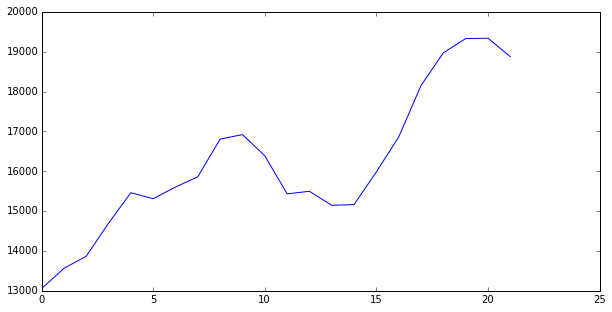

In [99]:
enrollments = pd.read_csv("DataSets/Enrollments.csv", sep=";")
enrollments = np.array(enrollments["Enrollments"])
fig = plt.figure(figsize=[10,5])
plot(enrollments)

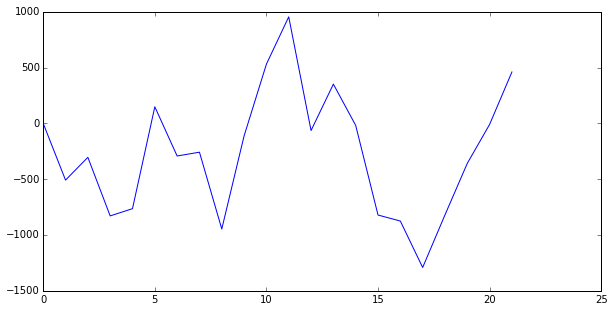

In [98]:
fig = plt.figure(figsize=[10,5])
plot(diferencas(enrollments))

### TAIEX - Taiwan Stock Exchange Index

O dataset foi provido por \cite{taiex2015}

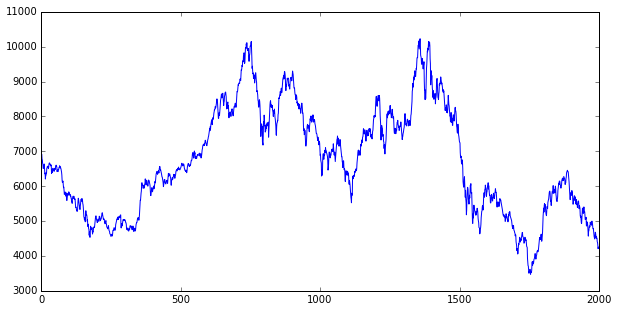

In [97]:
taiex = pd.read_csv("DataSets/TAIEX.csv", sep=",")
taiexsample = np.array(taiex["avg"][1:2000])
fig = plt.figure(figsize=[10,5])
plot(taiexsample)

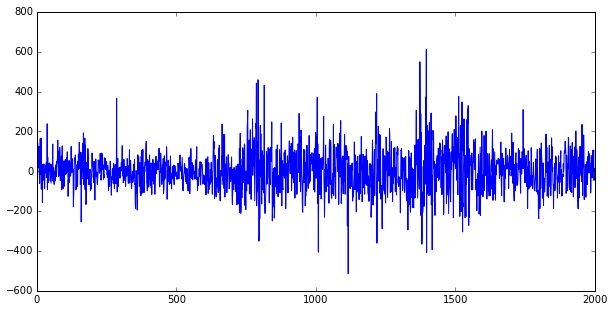

In [96]:
fig = plt.figure(figsize=[10,5])
plot(diferencas(taiexsample))
#np.array(taiexsample)

# Códigos Comuns

### Funções de Pertinência

In [15]:
def trimf(x,parameters):
	if(x < parameters[0]):
		return 0
	elif(x >= parameters[0] and x < parameters[1]):
		return (x-parameters[0])/(parameters[1]-parameters[0])
	elif(x >= parameters[1] and x <= parameters[2]):
		return (parameters[2]-x)/(parameters[2]-parameters[1])
	else: 
		return 0

def trapmf(x, parameters):
		if(x < parameters[0]):
			return 0
		elif(x >= parameters[0] and x < parameters[1]):
			return (x-parameters[0])/(parameters[1]-parameters[0])
		elif(x >= parameters[1] and x <= parameters[2]):
			return 1
		elif(x >= parameters[2] and x <= parameters[3]):
			return (parameters[3]-x)/(parameters[3]-parameters[2])
		else: 
			return 0

def gaussmf(x,parameters):
		return math.exp(-0.5*((x-parameters[0]) / parameters[1] )**2)


def bellmf(x,parameters):
		return 1 / (1 + abs((xx - parameters[2])/parameters[0])**(2*parameters[1]))


def sigmf(x,parameters):
		return 1 / (1 + math.exp(-parameters[0] * (x - parameters[1])))


### Conjuntos Nebulosos

In [16]:
class FuzzySet:

	def __init__(self,name,mf,parameters,centroid):
		self.name = name
		self.mf = mf
		self.parameters = parameters
		self.centroid = centroid
        
	def membership(self,x):
		return self.mf(x,self.parameters)
    
	def __str__(self):
		return self.name + ": " + str(self.mf) + "(" + str(self.parameters) + ")"
    
    

### Particionadores do Universo de Discurso

In [17]:
def GridPartitionerTrimf(data,npart,names = None,prefix = "A"):
	sets = []
	dmax = max(data)
	dmin = min(data)
	dlen = dmax - dmin
	partlen = dlen / npart
	partition = dmin
	for c in range(npart):
		sets.append( FuzzySet(prefix+str(c),trimf,[partition-partlen, partition, partition+partlen], partition ) )
		partition = partition + partlen
		
	return sets

In [18]:
sts = GridPartitionerTrimf(enrollments,10)
for s in sts:
    print(s)

A0: <function trimf at 0xaa1b6464>([12426.799999999999, 13055, 13683.200000000001])
A1: <function trimf at 0xaa1b6464>([13055.0, 13683.200000000001, 14311.400000000001])
A2: <function trimf at 0xaa1b6464>([13683.200000000001, 14311.400000000001, 14939.600000000002])
A3: <function trimf at 0xaa1b6464>([14311.400000000001, 14939.600000000002, 15567.800000000003])
A4: <function trimf at 0xaa1b6464>([14939.600000000002, 15567.800000000003, 16196.000000000004])
A5: <function trimf at 0xaa1b6464>([15567.800000000003, 16196.000000000004, 16824.200000000004])
A6: <function trimf at 0xaa1b6464>([16196.000000000004, 16824.200000000004, 17452.400000000005])
A7: <function trimf at 0xaa1b6464>([16824.200000000004, 17452.400000000005, 18080.600000000006])
A8: <function trimf at 0xaa1b6464>([17452.400000000005, 18080.600000000006, 18708.800000000007])
A9: <function trimf at 0xaa1b6464>([18080.600000000006, 18708.800000000007, 19337.000000000007])


In [19]:
class FTS:
	def __init__(self,order,name):
		self.sets = {}
		self.flrgs = {}
		self.order = order
		self.name = name
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best

	def defuzzy(self,data):
		pass

	def learn(self, data, sets):
		pass  

	def predict(self,data):
		return self.defuzzy(data)

	def predictDiff(self,data,t):
		return data[t] + self.defuzzy(data[t-1]-data[t])

	def __str__(self):
		tmp = self.name + ":\n"
		for r in self.flrgs.keys():
			tmp = tmp + str(self.flrgs[r]) + "\n"
		return tmp


# First Order Fuzzy Time Series

Os trabalhos pioneiros em séries temporais nebulosas são de \cite{song1993fuzzy} e a evolução apresentada por \cite{chen1996forecasting}. Nesses trabalhos define-se que o modelo de primeira ordem (\textit{First Order Fuzzy Time Series}) caracteriza-se por presumir que $F(t)$ é determinado unicamente por $F(t-1)$ ( ou $F(t-2)$ ou ... ou $F(t-m)$ ).

## FTS - Código Fonte

In [20]:
class FirstOrderFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = set()
	
	def append(self,c):
		self.consequent.add(c)

	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c
		return tmp + tmp2


In [21]:
class FirstOrderFTS(FTS):
	def __init__(self,name):
		super(FirstOrderFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		count = 0.0
		denom = 0.0

		for s in flrg.consequent:
			denom = denom + self.sets[s].centroid
			count = count + 1.0

		return denom/count
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = FirstOrderFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual
        

## FTS - Experimento com o dataset Enrollments

Série Original
4 824.468539217
8 1489.85136323
10 435.391975956
20 630.50536693
30 504.555710502

Série Diferencial
4 318.45943084
8 462.123024346
10 385.15987482
20 492.788040519
30 513.883680045


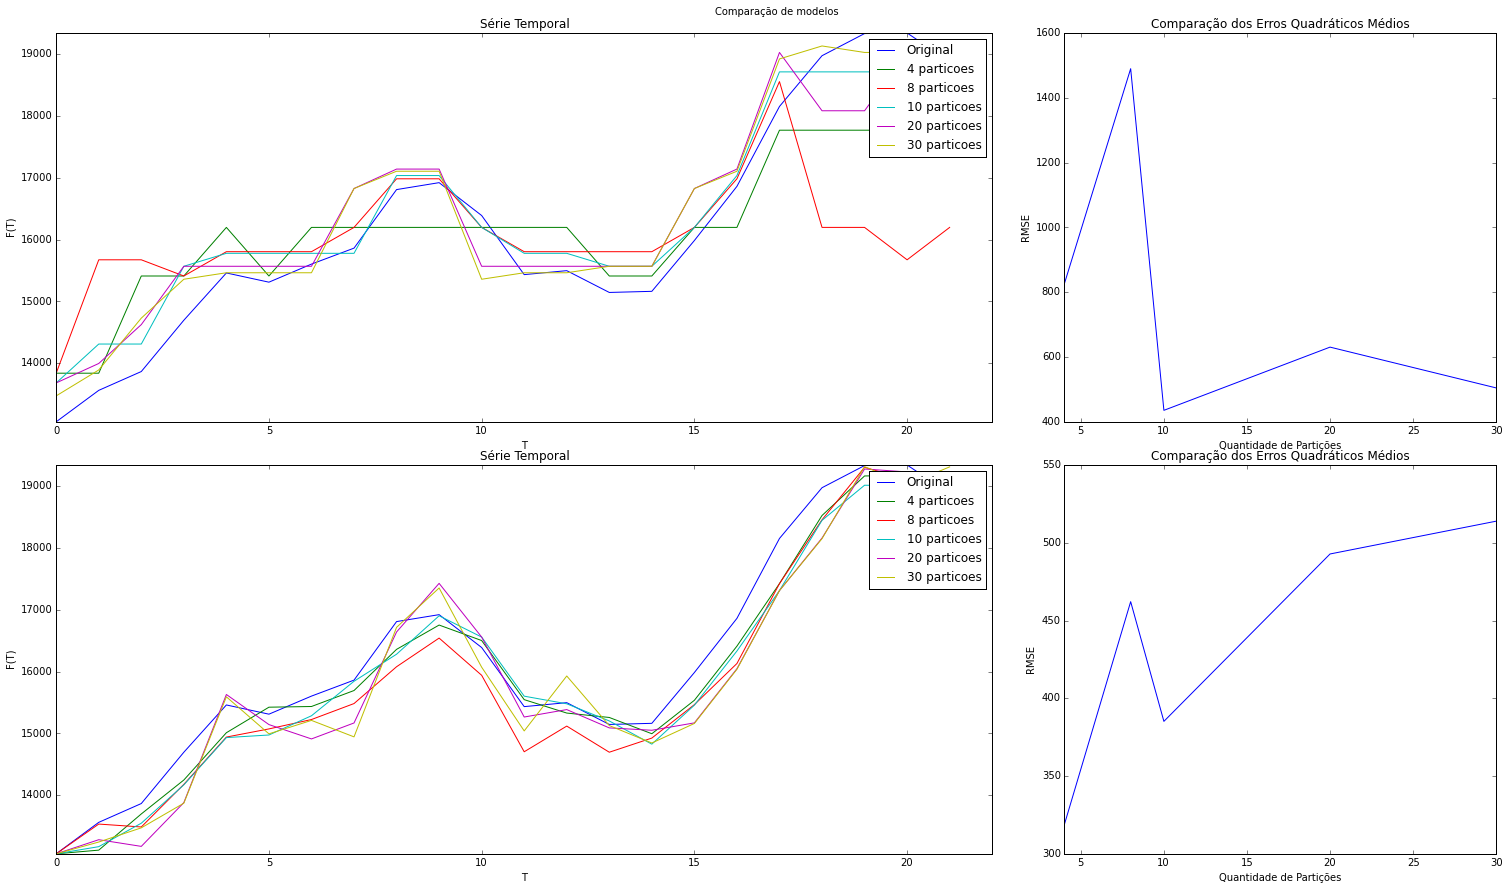

In [22]:
fts1,fts1p,ftsd1,ftsd1p = SelecaoSimples_MenorRMSE(enrollments,[4,8, 10,20, 30],FirstOrderFTS)

In [23]:
print(fts1)

10 particoes:
A0 -> A1
A6 -> A6,A5,A8
A5 -> A4,A6
A3 -> A4,A5,A3
A4 -> A4,A6,A3
A9 -> A9
A1 -> A1,A3
A8 -> A9



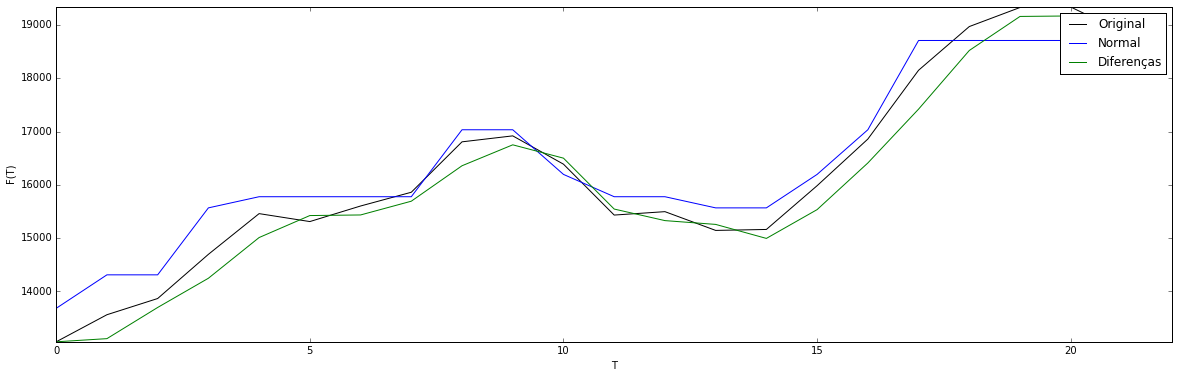

In [24]:
plotCompared(enrollments,[fts1p,ftsd1p],["Normal","Diferenças"],'')
enrolments_modelbase_fo.append({"name":"FTS","model":fts1,"predicted":fts1p})
enrolments_modelbase_fo.append({"name":"FTS Dif.","model":ftsd1,"predicted":ftsd1p})

## FTS - Experimento com o dataset TAIEX

Série Original
0 10 199.873647999
0 15 130.202701911
0 20 94.2070950366
0 25 78.6505526659
0 30 244.570087966
0 35 90.6568444078
1 10 332.114316343
1 15 207.234853698
1 20 143.926633637
1 25 136.921627024
1 30 395.960841822
1 35 89.8036289868
2 10 186.445272344
2 15 136.17258399
2 20 121.878069043
2 25 116.678346067
2 30 273.584531751
2 35 84.4098587618
3 10 372.602475581
3 15 280.568365173
3 20 389.314036614
3 25 372.462096818
3 30 403.369130404
3 35 191.302007064
4 10 1470.07412034
4 15 1820.12617247
4 20 1682.72427989
4 25 1540.13132105
4 30 1156.84806365
4 35 2143.85797342

Série Diferencial
0 10 63.0426005645
0 15 35.0260661753
0 20 46.0256257953
0 25 33.3927309063
0 30 38.56795484
0 35 39.0551866268
1 10 51.2676362909
1 15 43.8078872614
1 20 47.6139575343
1 25 40.6333917422
1 30 38.4400391198
1 35 48.7708958374
2 10 71.2729311547
2 15 66.8766094156
2 20 71.5706563389
2 25 63.3542735368
2 30 57.5989874657
2 35 69.9883131833
3 10 61.3851127157
3 15 66.8146148313
3 20 56.0785945588


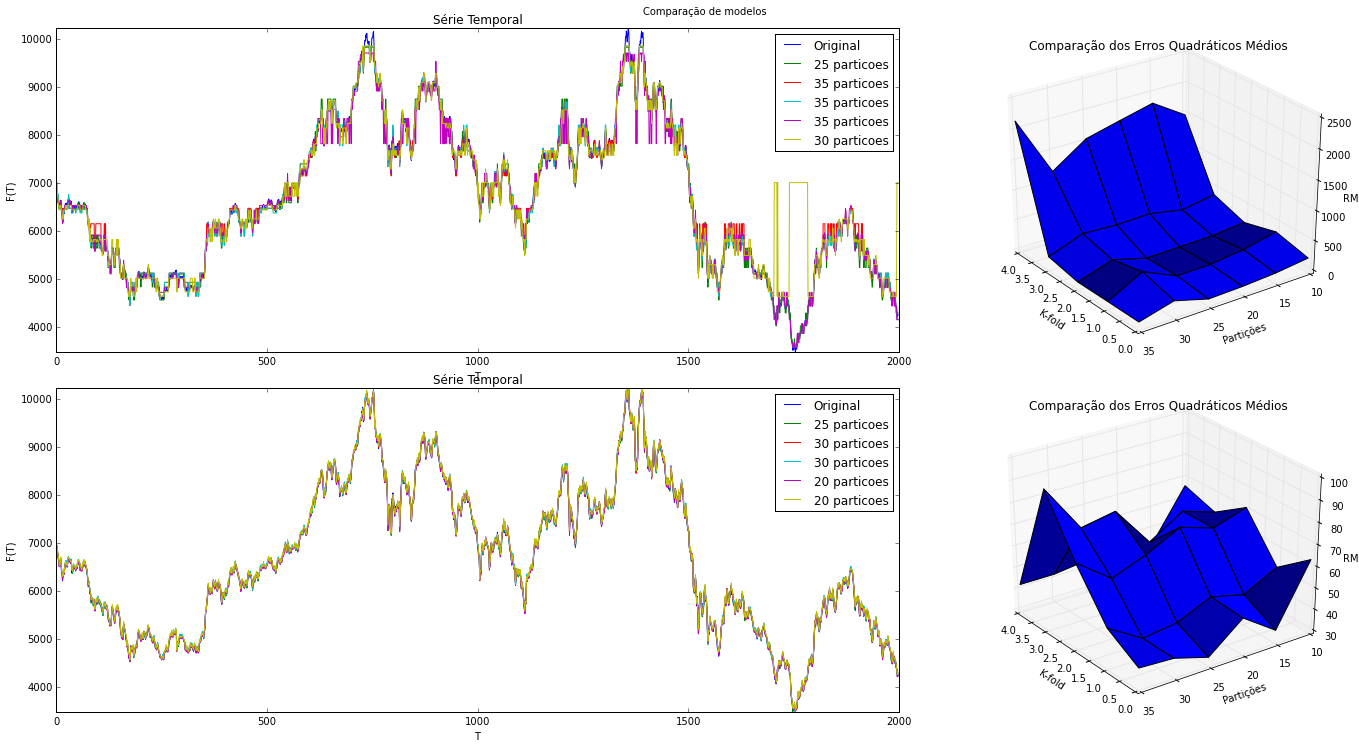

In [102]:
fts2,fts2p,ftsd2,ftsd2p= SelecaoKFold_MenorRMSE(taiexsample,[10,15,20,25,30,35],FirstOrderFTS)

In [26]:
print(ftsd2)

25 particoes:
A14 -> A14,A15,A6,A5,A16,A9,A17,A8,A12,A19,A7,A20,A11,A10,A13,A18
A6 -> A6,A5,A16,A9,A8,A12,A7,A11,A10,A13
A19 -> A12,A8
A11 -> A14,A15,A6,A16,A9,A12,A8,A7,A11,A10,A13,A18
A3 -> A4,A10
A10 -> A14,A15,A6,A3,A16,A2,A9,A24,A12,A8,A17,A7,A11,A10,A22,A13
A9 -> A14,A15,A6,A5,A16,A9,A17,A12,A8,A7,A11,A10,A21,A13
A17 -> A14,A15,A16,A9,A19,A12,A11,A18,A13
A8 -> A14,A6,A5,A9,A12,A8,A7,A11,A10,A13
A7 -> A14,A3,A9,A17,A12,A8,A7,A11,A10
A21 -> A8
A2 -> A9,A12
A4 -> A4,A13,A9
A12 -> A14,A15,A6,A5,A16,A9,A17,A12,A8,A7,A0,A20,A11,A10,A13,A18
A18 -> A14,A15,A6,A17,A12,A8,A11,A10,A13
A24 -> A18
A15 -> A14,A15,A16,A9,A12,A8,A20,A11,A10,A13,A18
A5 -> A10,A8,A14,A9,A12
A16 -> A15,A16,A9,A17,A12,A7,A11,A21,A10,A13,A18
A0 -> A11
A20 -> A13,A15,A3,A8
A22 -> A12
A13 -> A14,A15,A6,A16,A2,A9,A17,A8,A12,A7,A11,A10,A13,A4,A18



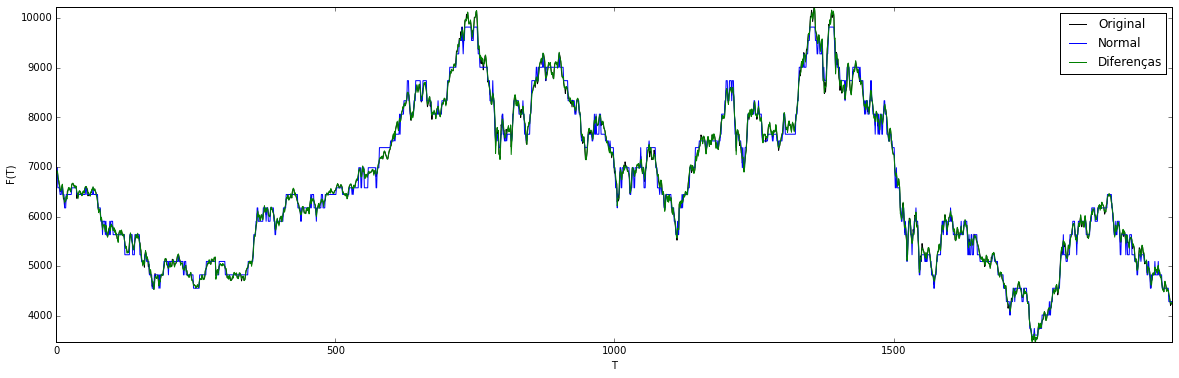

In [27]:
plotCompared(taiexsample,[fts2p,ftsd2p],["Normal","Diferenças"],'')
taiex_modelbase_fo.append({"name":"FTS","model":fts2,"predicted":fts2p})
taiex_modelbase_fo.append({"name":"FTS Dif.","model":ftsd2,"predicted":ftsd2p})

# Weighted Fuzzy Time Series

O trabalho de \cite{yu2005weighted} propõe um modelo  - as \textit{Weighted Fuzzy Time Series} -  em que os grupos de regras permitem repetições no consequente e tenham ponderação monotonicamente crescente, baseado na ordem cronológica dos termos no consequente. Nesse modelo as FLRG's permitem a repetição de conjuntos no consequente das regras, e os conjuntos devem ser apresentados em ordem cronológica.


## WFTS - Código Fonte

In [28]:
class WeightedFLRG(FTS):
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = []
		self.count = 1.0

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		tot = sum( np.arange(1.0,self.count,1.0) )
		return np.array([ k/tot for k in np.arange(1.0,self.count,1.0) ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 1.0
		tot = sum( np.arange(1.0,self.count,1.0) )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(cc/tot) + ")"
			cc = cc + 1.0
		return tmp + tmp2

In [29]:
class WeightedFTS(FTS):
	def __init__(self,name):
		super(WeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = WeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## WFTS - Experimento com o dataset Enrollments

Série Original
6 1469.11529887
8 1736.75458077
10 489.718215586
12 669.096511757
14 523.447886773

Série Diferencial
6 502.659582059
8 400.937452453
10 404.600907881
12 398.685259658
14 489.728297622


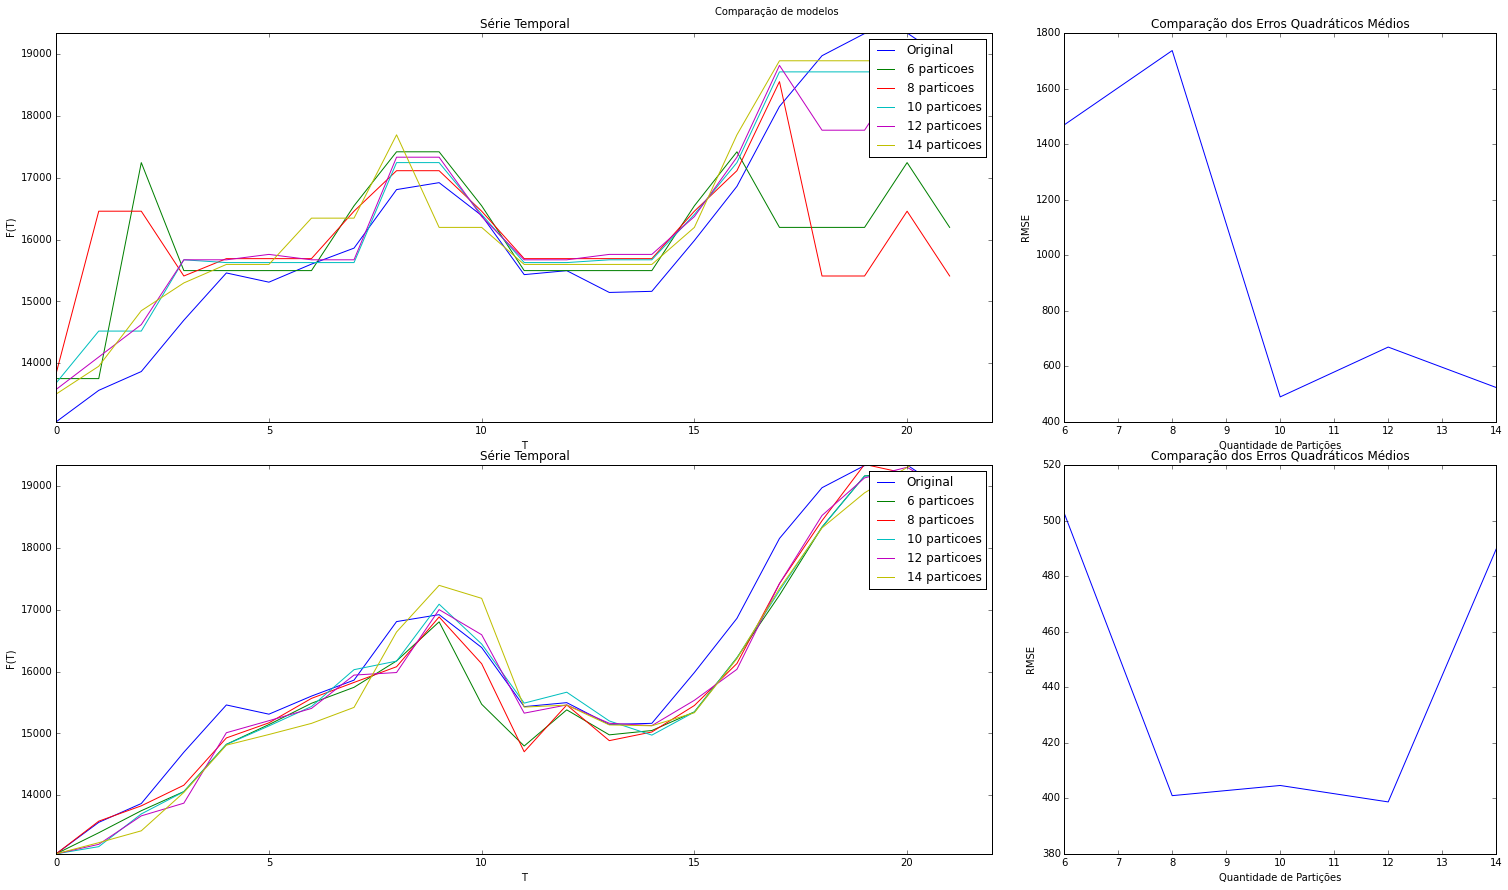

In [30]:
wfts1,wfts1p,wftsd1,wftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], WeightedFTS)

In [31]:
print(wfts1)

10 particoes:
A0 -> A1(1.0)
A6 -> A6(0.166666666667),A5(0.333333333333),A8(0.5)
A5 -> A4(0.333333333333),A6(0.666666666667)
A3 -> A4(0.166666666667),A3(0.333333333333),A5(0.5)
A4 -> A4(0.047619047619),A4(0.0952380952381),A4(0.142857142857),A6(0.190476190476),A4(0.238095238095),A3(0.285714285714)
A9 -> A9(0.166666666667),A9(0.333333333333),A9(0.5)
A1 -> A1(0.333333333333),A3(0.666666666667)
A8 -> A9(1.0)



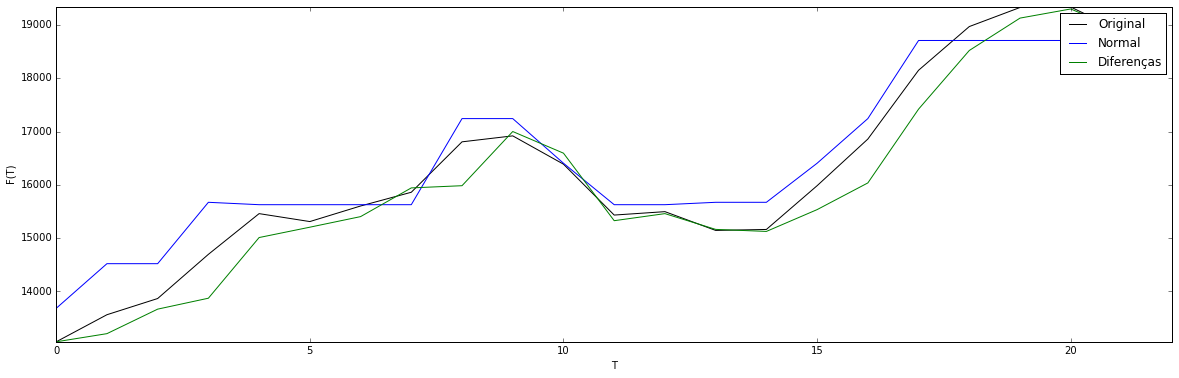

In [32]:
plotCompared(enrollments,[wfts1p,wftsd1p],["Normal","Diferenças"],'')
enrolments_modelbase_fo.append({"name":"WFTS","model":wfts1,"predicted":wfts1p})
enrolments_modelbase_fo.append({"name":"WFTS Dif.","model":wftsd1,"predicted":wftsd1p})

## WFTS - Experimento com o dataset TAIEX

Série Original
0 2 1134.31988753
0 5 306.101184895
0 10 211.654861979
0 15 133.047922956
0 20 93.6094013008
0 25 77.5784468693
0 30 66.6305913671
0 35 58.9294204783
1 2 1422.85437658
1 5 490.766314004
1 10 232.949369062
1 15 151.383244689
1 20 103.073132767
1 25 83.130777915
1 30 91.6492993623
1 35 65.7161284205
2 2 1143.34685399
2 5 383.998205071
2 10 193.203077473
2 15 139.309184977
2 20 100.589969335
2 25 75.3914287192
2 30 75.2167667994
2 35 60.4872530915
3 2 1651.99887594
3 5 546.606644545
3 10 270.770337911
3 15 179.333327954
3 20 272.296502395
3 25 334.998128675
3 30 388.336393866
3 35 114.97157321
4 2 792.567657984
4 5 383.418913212
4 10 1456.11147281
4 15 1811.64732597
4 20 1531.67083588
4 25 1352.22019867
4 30 1146.35704414
4 35 2154.96750054

Série Diferencial
0 2 41.8288977534
0 5 20.2537652398
0 10 24.5597336835
0 15 22.1443368427
0 20 22.6338319428
0 25 21.6514837976
0 30 27.0131645563
0 35 25.3897633536
1 2 41.7054991679
1 5 23.0428704493
1 10 28.6578935126
1 15 35.41507

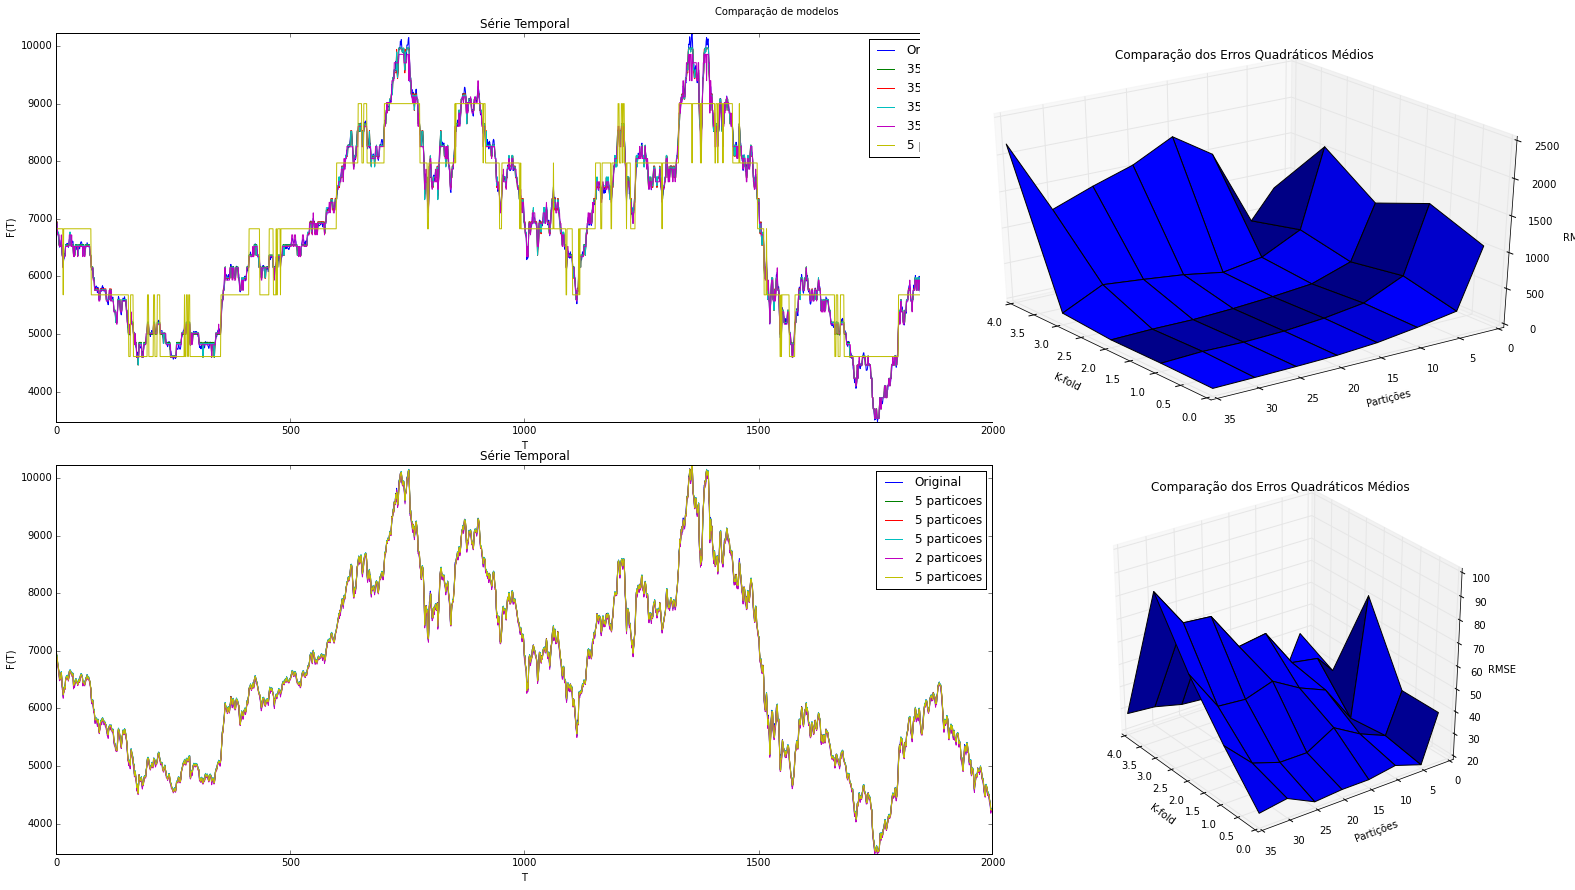

In [33]:
wfts2,wfts2p,wftsd2,wftsd2p = SelecaoKFold_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], WeightedFTS)

In [34]:
print(wfts2)

35 particoes:
A14 -> A14(0.000438981562774),A14(0.000877963125549),A14(0.00131694468832),A14(0.0017559262511),A15(0.00219490781387),A14(0.00263388937665),A14(0.00307287093942),A14(0.00351185250219),A14(0.00395083406497),A13(0.00438981562774),A14(0.00482879719052),A14(0.00526777875329),A14(0.00570676031607),A14(0.00614574187884),A14(0.00658472344162),A13(0.00702370500439),A14(0.00746268656716),A14(0.00790166812994),A14(0.00834064969271),A14(0.00877963125549),A14(0.00921861281826),A14(0.00965759438104),A15(0.0100965759438),A14(0.0105355575066),A14(0.0109745390694),A13(0.0114135206321),A14(0.0118525021949),A14(0.0122914837577),A14(0.0127304653205),A14(0.0131694468832),A14(0.013608428446),A14(0.0140474100088),A15(0.0144863915716),A15(0.0149253731343),A14(0.0153643546971),A15(0.0158033362599),A13(0.0162423178227),A14(0.0166812993854),A13(0.0171202809482),A15(0.017559262511),A15(0.0179982440737),A15(0.0184372256365),A13(0.0188762071993),A14(0.0193151887621),A13(0.0197541703248),A13(0.0201931

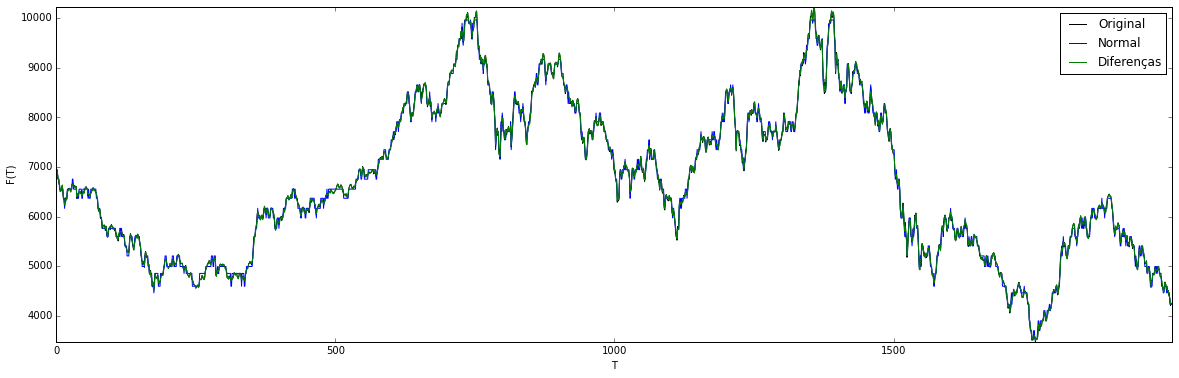

In [35]:
plotCompared(taiexsample,[wfts2p,wftsd2p],["Normal","Diferenças"],'')
taiex_modelbase_fo.append({"name":"WFTS","model":wfts2,"predicted":wfts2p})
taiex_modelbase_fo.append({"name":"WFTS Dif.","model":wftsd2,"predicted":wftsd2p})

# Improved Weighted Fuzzy Time Series

Os trabalhos de \cite{ismail2011enrollment} e \cite{efendi2013improved} modificam a forma como os pesos são assinalados às regras no modelo de \cite{yu2005weighted}. A diferença mais importante é que a quantidade de recorrências de cada regra é que vai determinar o seu peso, para uma regra $A_i \rightarrow A_j,A_k$, tendo $A_i \rightarrow A_j$ $n_1$ recorrências e $A_i \rightarrow A_k$ $n_2$ recorrências, o valor de cada peso será $w_k = n_k / \sum_{i=1..n} n_i$, sendo $n$ o número de regras.

## IWFTS - Código Fonte

In [36]:
class ImprovedWeightedFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = {}
		self.count = 0.0

	def append(self,c):
		if c not in self.consequent:
			self.consequent[c] = 1.0
		else:
			self.consequent[c] = self.consequent[c] + 1.0
		self.count = self.count + 1.0

	def weights(self):
		return np.array([ self.consequent[c]/self.count for c in self.consequent.keys() ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent.keys():
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(self.consequent[c]/self.count) + ")"
		return tmp + tmp2

In [37]:
class ImprovedWeightedFTS(FTS):
	def __init__(self,name):
		super(ImprovedWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
		actual = self.fuzzy(data)
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid
		flrg = self.flrgs[actual["fuzzyset"]]
		mi = np.array([self.sets[s].centroid for s in flrg.consequent.keys()])
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ImprovedWeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## IWFTS - Experimento com o dataset Enrollments

Série Original
6 1223.85830842
8 1483.3701904
10 422.250747348
12 570.537792052
14 482.697281037

Série Diferencial
6 484.842445186
8 399.931984881
10 405.181426862
12 382.097267165
14 498.167600324


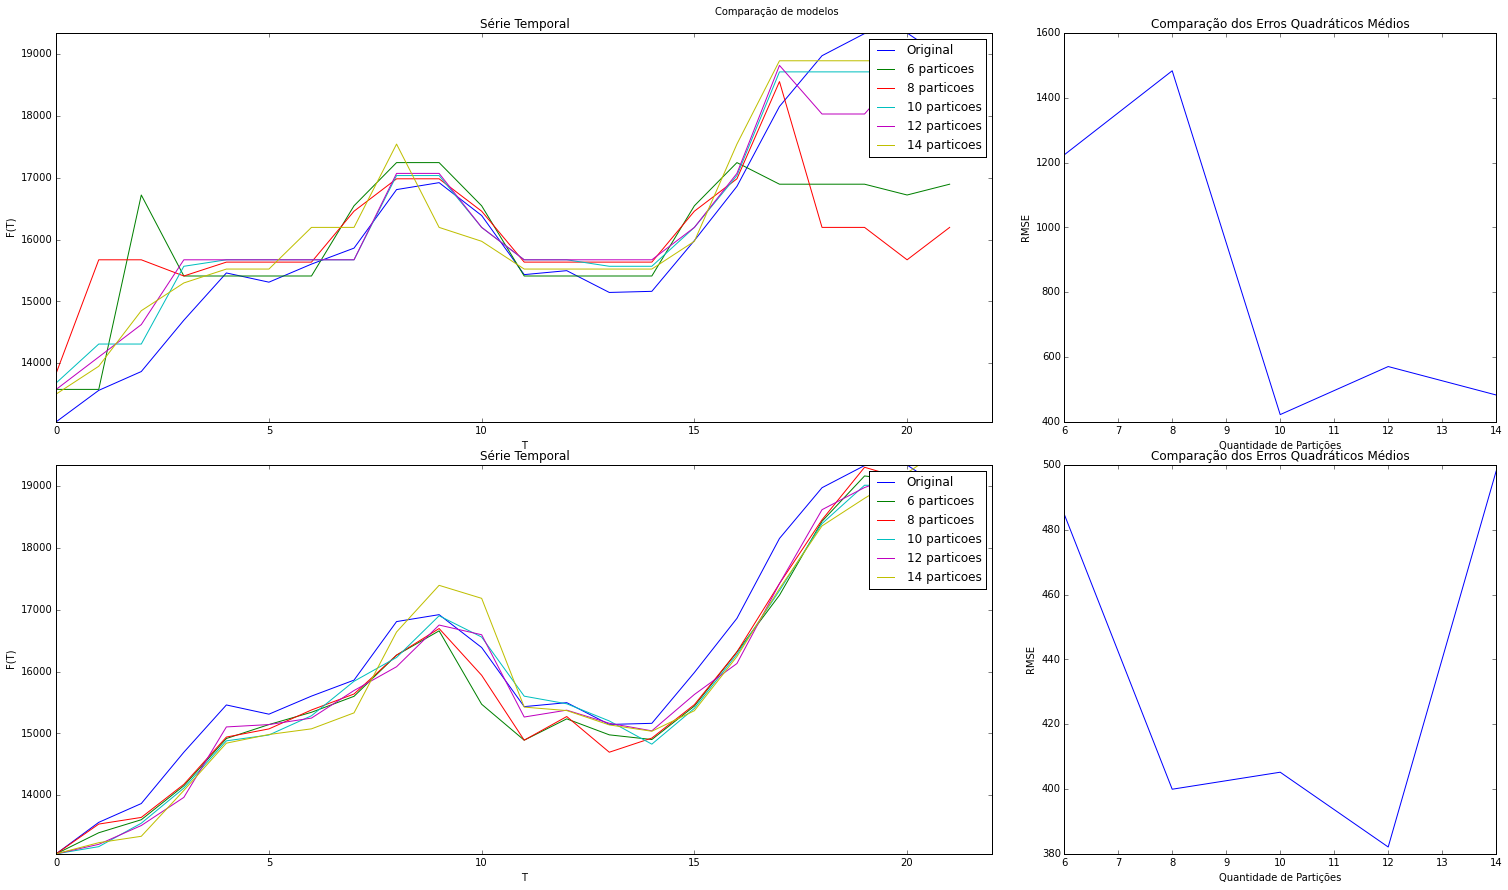

In [38]:
#fts = ImprovedWeightedFTS()
#sets = GridPartitionerTrimf(enrollments["Enrollments"],8)
#fts.learn(enrollments["Enrollments"],sets)

iwfts1,iwfts1p,iwftsd1,iwftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], ImprovedWeightedFTS)

In [39]:
print(iwfts1)

10 particoes:
A0 -> A1(1.0)
A6 -> A6(0.3333333333333333),A5(0.3333333333333333),A8(0.3333333333333333)
A5 -> A4(0.5),A6(0.5)
A3 -> A4(0.3333333333333333),A5(0.3333333333333333),A3(0.3333333333333333)
A4 -> A4(0.6666666666666666),A6(0.16666666666666666),A3(0.16666666666666666)
A9 -> A9(1.0)
A1 -> A1(0.5),A3(0.5)
A8 -> A9(1.0)



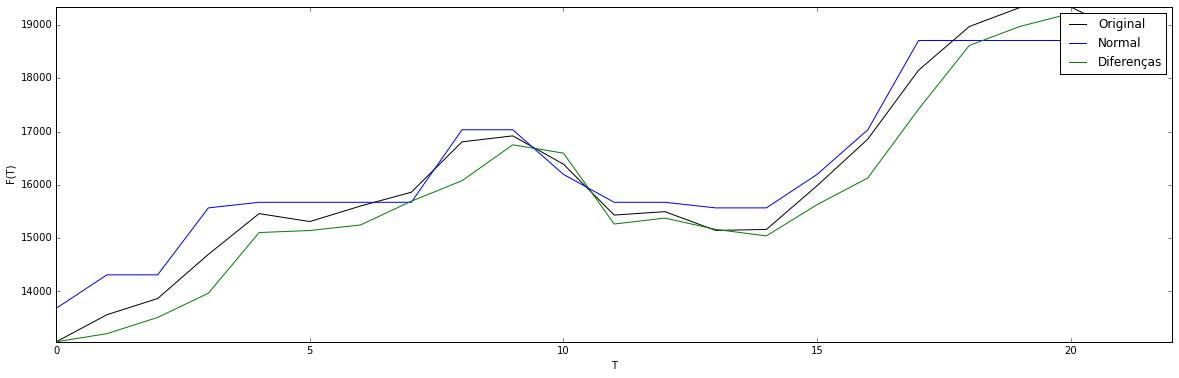

In [40]:
plotCompared(enrollments,[iwfts1p,iwftsd1p],["Normal","Diferenças"],'')
enrolments_modelbase_fo.append({"name":"IWFTS","model":iwfts1,"predicted":iwfts1p})
enrolments_modelbase_fo.append({"name":"IWFTS Dif.","model":iwftsd1,"predicted":iwftsd1p})


## IWFTS - Experimento com o dataset TAIEX

Série Original
0 2 1102.43154749
0 5 306.588479104
0 10 201.737951925
0 15 131.332904884
0 20 95.2517421796
0 25 79.4023447013
0 30 66.1376923757
0 35 55.6434046179
1 2 1414.48412767
1 5 484.937675917
1 10 225.554926179
1 15 148.603661133
1 20 99.6499378843
1 25 80.375164683
1 30 89.2448698306
1 35 62.575357917
2 2 1133.20070357
2 5 379.654360705
2 10 192.815117126
2 15 136.883015714
2 20 101.667451046
2 25 77.1415051272
2 30 71.8992533785
2 35 61.1943844612
3 2 1649.34045533
3 5 545.206084041
3 10 262.86952491
3 15 175.499456287
3 20 266.113694025
3 25 335.418683079
3 30 387.454755561
3 35 105.346876208
4 2 808.881297
4 5 380.849452299
4 10 1456.16766339
4 15 1818.64085321
4 20 1531.19319377
4 25 1345.86251517
4 30 1140.42739904
4 35 2187.23076974

Série Diferencial
0 2 42.2264698415
0 5 22.2412799468
0 10 24.2123256813
0 15 22.3954630774
0 20 21.4742051968
0 25 21.6689147893
0 30 26.0586288987
0 35 24.1802921642
1 2 42.1614735791
1 5 23.6376827325
1 10 27.5703906196
1 15 33.483448623

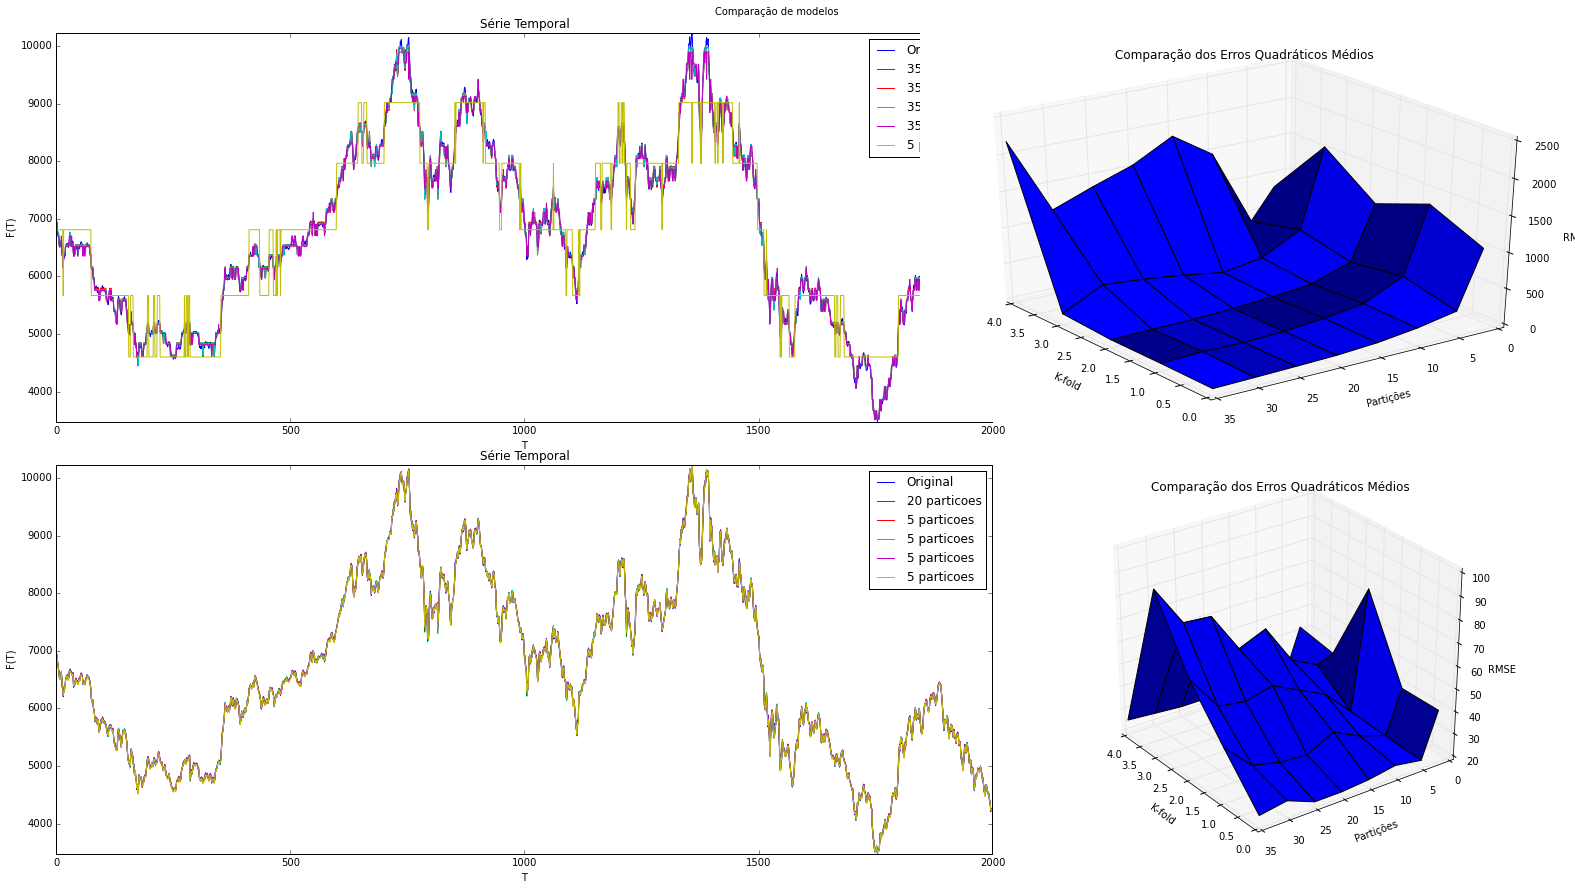

In [41]:
iwfts2,iwfts2p,iwftsd2,iwftsd2p = SelecaoKFold_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], ImprovedWeightedFTS)

In [42]:
print(iwfts2)

35 particoes:
A14 -> A14(0.6716417910447762),A13(0.1791044776119403),A15(0.14925373134328357)
A0 -> A0(0.75),A1(0.25)
A8 -> A7(0.1794871794871795),A10(0.02564102564102564),A9(0.1794871794871795),A8(0.6153846153846154)
A6 -> A7(0.09375),A6(0.6875),A5(0.21875)
A32 -> A33(0.23809523809523808),A32(0.47619047619047616),A29(0.047619047619047616),A31(0.23809523809523808)
A3 -> A4(0.2727272727272727),A2(0.09090909090909091),A3(0.6363636363636364)
A1 -> A1(0.5),A2(0.25),A0(0.25)
A10 -> A9(0.15384615384615385),A11(0.23076923076923078),A10(0.6153846153846154)
A9 -> A8(0.2),A9(0.64),A10(0.16)
A19 -> A18(0.16279069767441862),A21(0.023255813953488372),A19(0.6046511627906976),A20(0.20930232558139536)
A17 -> A16(0.09090909090909091),A18(0.25),A15(0.045454545454545456),A17(0.6136363636363636)
A24 -> A23(0.23863636363636365),A25(0.17045454545454544),A24(0.5909090909090909)
A7 -> A7(0.6296296296296297),A6(0.14814814814814814),A9(0.037037037037037035),A8(0.18518518518518517)
A25 -> A25(0.6052631578947368)

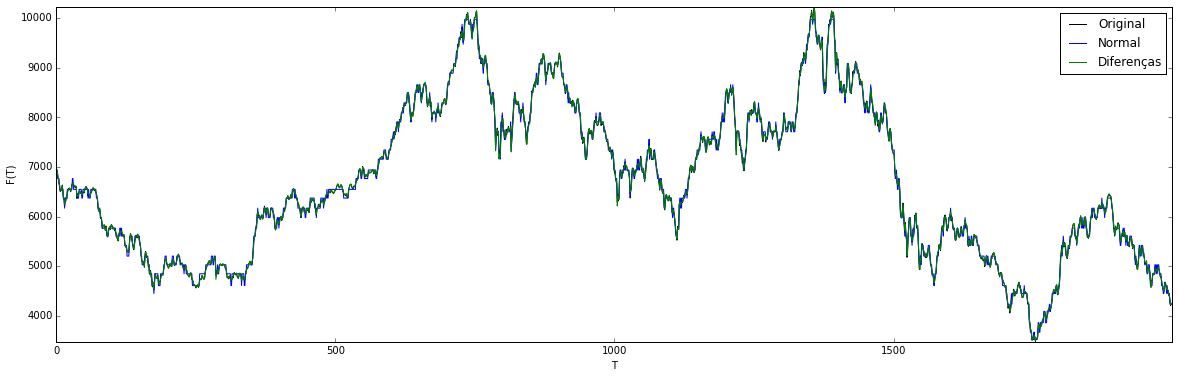

In [43]:
plotCompared(taiexsample,[iwfts2p,iwftsd2p],["Normal","Diferenças"],'')
taiex_modelbase_fo.append({"name":"IWFTS","model":iwfts2,"predicted":iwfts2p})
taiex_modelbase_fo.append({"name":"IWFTS Dif.","model":iwftsd2,"predicted":iwftsd2p})

# Exponentialy Weighted Fuzzy Time Series

O método EWFTS - \textit{Exponentialy Weighted Fuzzy Time Series}, é utilizado em \cite{sadaei2014short}, e contrasta com o crescimento linear dos pesos proposto por \cite{yu2005weighted} modificando-os por um crescimento exponencial. Dada a FLRG $A_i \rightarrow A_1,A_3,...,A_k$, a matriz $M(t) = [m_1, m_2, ...,m_k]$ dos centros de $A_1,A_3,...,A_k$ a matriz de pesos $w(t)$ será definida por um parâmetro $c$, que formará a série exponencial $c^0, c^1, ..., c^{k-1}$ normalizada. O parâmetro $c$ deve ser maior do que zero.

$$
w(t) = \left[ \frac{1}{\sum_{h=1}^k c^{h-1}},\frac{c^1}{\sum_{h=1}^k c^{h-1}},...,\frac{c^{k-1}}{\sum_{h=1}^k c^{h-1}} \right]
$$

## EWFTS - Código Fonte

In [44]:
class ExponentialyWeightedFLRG:
	def __init__(self,premiss,c):
		self.premiss = premiss
		self.consequent = []
		self.count = 0.0
		self.c = c

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		return np.array([ k/tot for k in wei ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 0
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(wei[cc]/tot) + ")"
			cc = cc + 1
		return tmp + tmp2

In [45]:
class ExponentialyWeightedFTS(FTS):
	def __init__(self,name):
		super(ExponentialyWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ExponentialyWeightedFLRG(last["fuzzyset"],2)
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## EWFTS - Experimento com o dataset Enrollments

Série Original
6 1595.03329663
8 1774.84095057
10 519.438292024
12 689.880524451
14 553.604229768

Série Diferencial
6 541.56601998
8 425.525684217
10 405.970793118
12 413.933252692
14 469.826090164


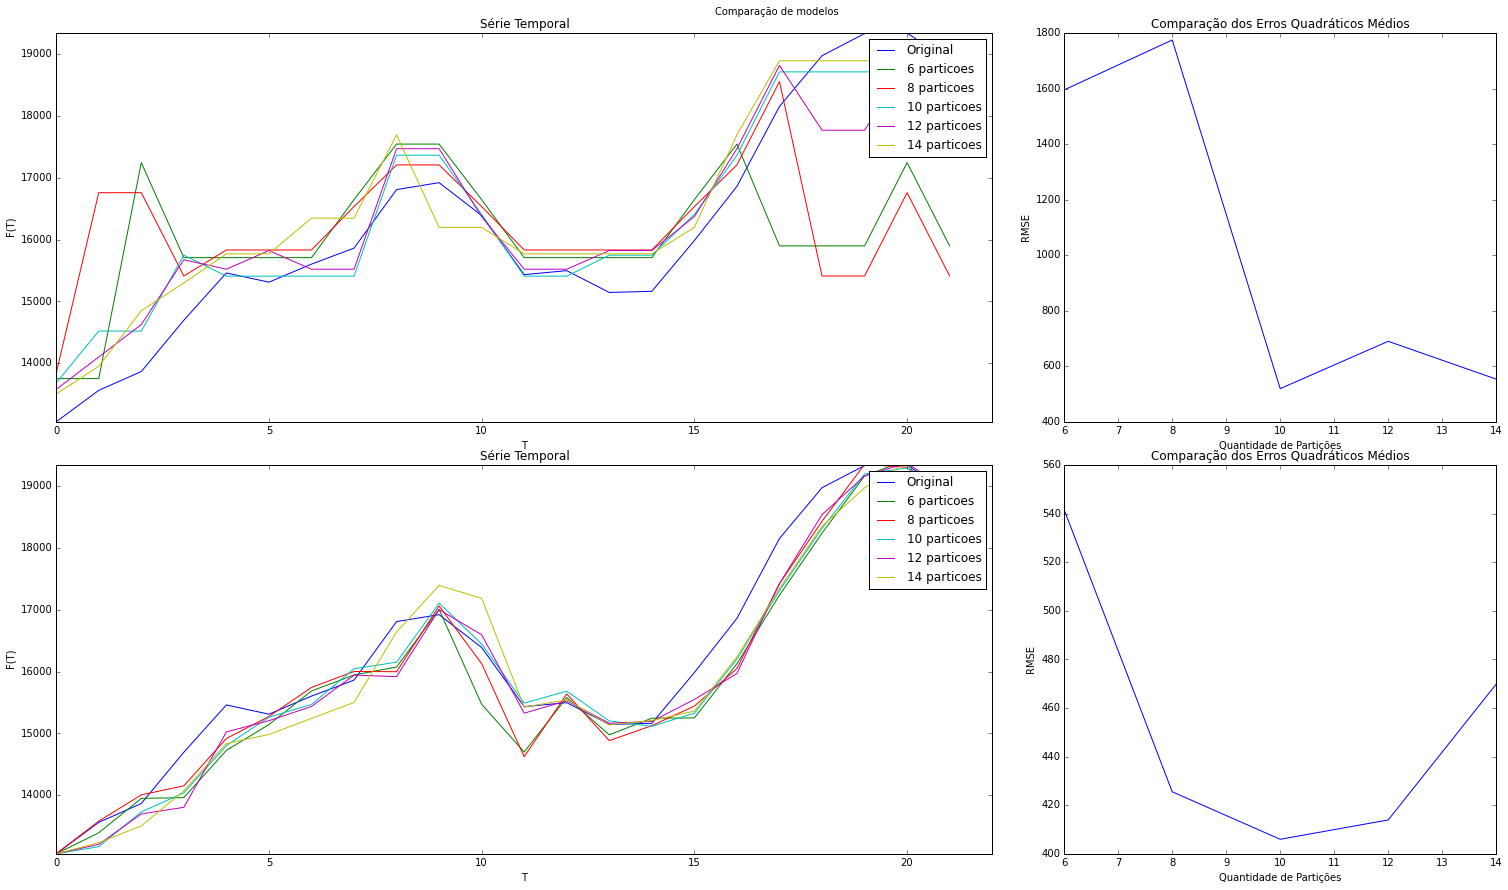

In [46]:
ewfts1,ewfts1p,ewftsd1,ewftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], ExponentialyWeightedFTS)

In [47]:
print(ewfts1)

10 particoes:
A0 -> A1(1.0)
A6 -> A6(0.142857142857),A5(0.285714285714),A8(0.571428571429)
A5 -> A4(0.333333333333),A6(0.666666666667)
A3 -> A4(0.142857142857),A3(0.285714285714),A5(0.571428571429)
A4 -> A4(0.015873015873),A4(0.031746031746),A4(0.0634920634921),A6(0.126984126984),A4(0.253968253968),A3(0.507936507937)
A9 -> A9(0.142857142857),A9(0.285714285714),A9(0.571428571429)
A1 -> A1(0.333333333333),A3(0.666666666667)
A8 -> A9(1.0)



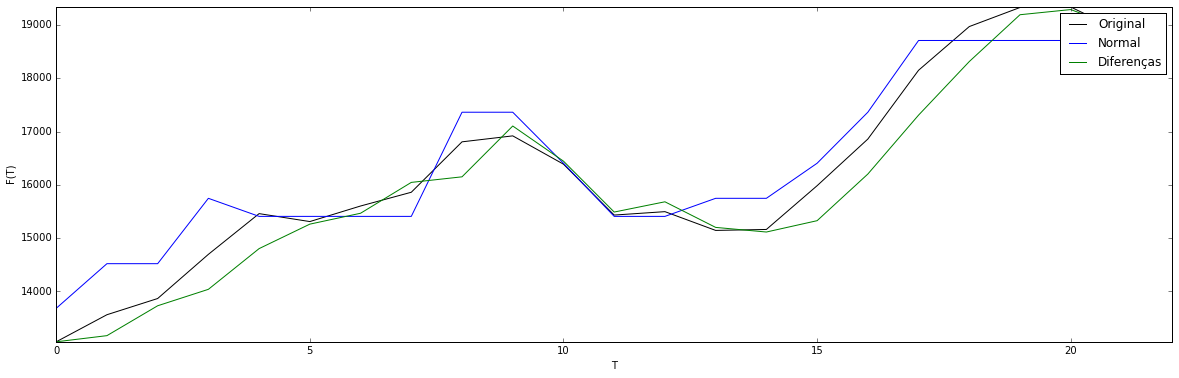

In [48]:
plotCompared(enrollments,[ewfts1p,ewftsd1p],["Normal","Diferenças"],'')
enrolments_modelbase_fo.append({"name":"EWFTS","model":ewfts1,"predicted":ewfts1p})
enrolments_modelbase_fo.append({"name":"EWFTS Dif.","model":ewftsd1,"predicted":ewftsd1p})

## EWFTS - Experimento com o dataset TAIEX

Série Original
0 2 1102.43154749
0 5 306.588479104
0 10 201.737951925
0 15 131.332904884
0 20 95.2517421796
0 25 79.4023447013
0 30 66.1376923757
0 35 55.6434046179
1 2 1414.48412767
1 5 484.937675917
1 10 225.554926179
1 15 148.603661133
1 20 99.6499378843
1 25 80.375164683
1 30 89.2448698306
1 35 62.575357917
2 2 1133.20070357
2 5 379.654360705
2 10 192.815117126
2 15 136.883015714
2 20 101.667451046
2 25 77.1415051272
2 30 71.8992533785
2 35 61.1943844612
3 2 1649.34045533
3 5 545.206084041
3 10 262.86952491
3 15 175.499456287
3 20 266.113694025
3 25 335.418683079
3 30 387.454755561
3 35 105.346876208
4 2 808.881297
4 5 380.849452299
4 10 1456.16766339
4 15 1818.64085321
4 20 1531.19319377
4 25 1345.86251517
4 30 1140.42739904
4 35 2187.23076974

Série Diferencial
0 2 42.2264698415
0 5 22.2412799468
0 10 24.2123256813
0 15 22.3954630774
0 20 21.4742051968
0 25 21.6689147893
0 30 26.0586288987
0 35 24.1802921642
1 2 42.1614735791
1 5 23.6376827325
1 10 27.5703906196
1 15 33.483448623

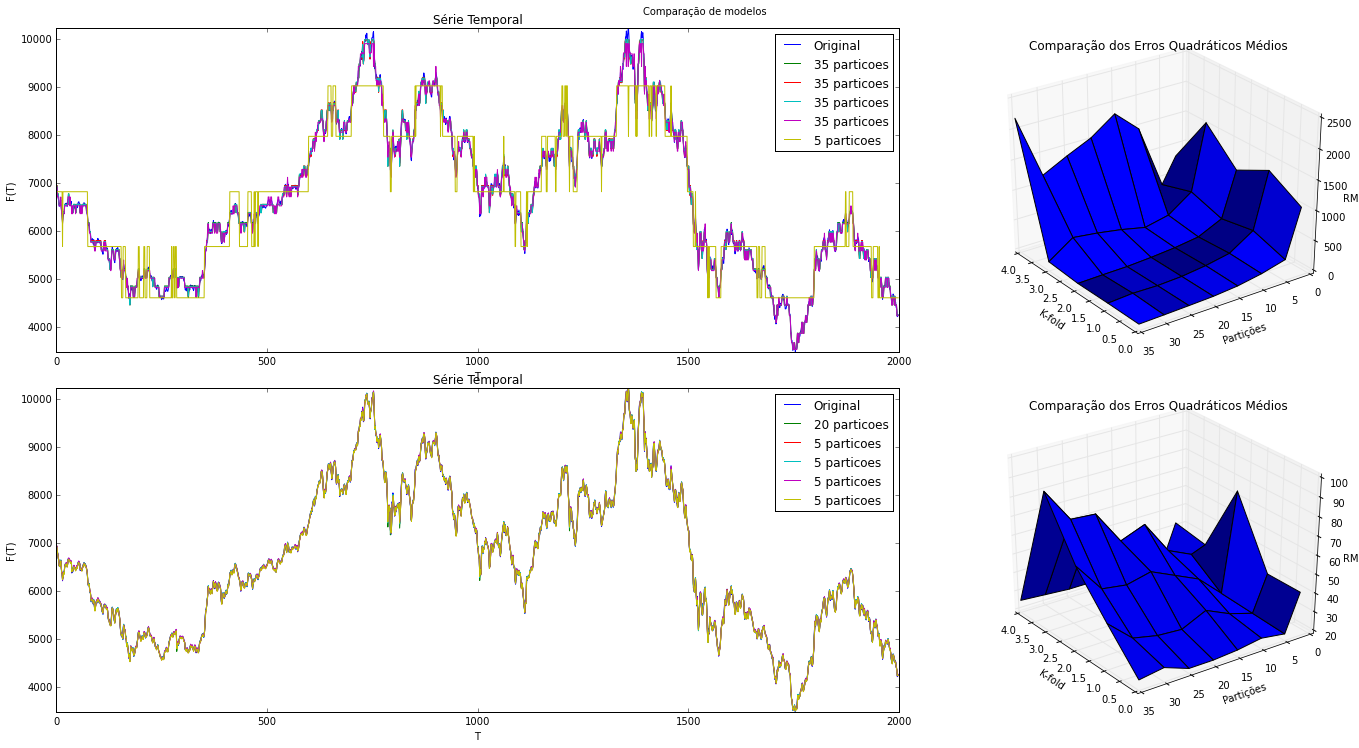

In [129]:
ewfts2,ewfts2p,ewftsd2,ewftsd2p = SelecaoKFold_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], ImprovedWeightedFTS)

In [50]:
print(ewfts2)

35 particoes:
A14 -> A14(0.6716417910447762),A13(0.1791044776119403),A15(0.14925373134328357)
A0 -> A0(0.75),A1(0.25)
A8 -> A7(0.1794871794871795),A10(0.02564102564102564),A9(0.1794871794871795),A8(0.6153846153846154)
A6 -> A7(0.09375),A6(0.6875),A5(0.21875)
A32 -> A33(0.23809523809523808),A32(0.47619047619047616),A29(0.047619047619047616),A31(0.23809523809523808)
A3 -> A4(0.2727272727272727),A2(0.09090909090909091),A3(0.6363636363636364)
A1 -> A1(0.5),A2(0.25),A0(0.25)
A10 -> A9(0.15384615384615385),A11(0.23076923076923078),A10(0.6153846153846154)
A9 -> A8(0.2),A9(0.64),A10(0.16)
A19 -> A18(0.16279069767441862),A21(0.023255813953488372),A19(0.6046511627906976),A20(0.20930232558139536)
A17 -> A16(0.09090909090909091),A18(0.25),A15(0.045454545454545456),A17(0.6136363636363636)
A24 -> A23(0.23863636363636365),A25(0.17045454545454544),A24(0.5909090909090909)
A7 -> A7(0.6296296296296297),A6(0.14814814814814814),A9(0.037037037037037035),A8(0.18518518518518517)
A25 -> A25(0.6052631578947368)

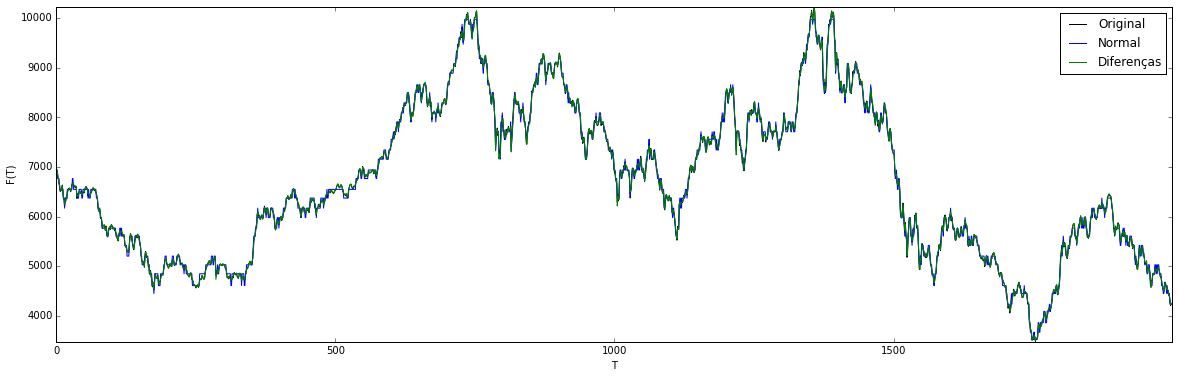

In [51]:
plotCompared(taiexsample,[ewfts2p,ewftsd2p],["Normal","Diferenças"],'')
taiex_modelbase_fo.append({"name":"EWFTS","model":ewfts2,"predicted":ewfts2p})
taiex_modelbase_fo.append({"name":"EWFTS Dif.","model":ewftsd2,"predicted":ewftsd2p})

# High Order Fuzzy Time Series

Essa implementação segue os trabalho de \cite{hwang1998handling} e \cite{chen2014high}. Esses modelos se diferenciam dos modelos de primeira ordem pelo uso de $m$ preditores em conjunto, $F(t-1),...,F(t-m)$ tal que $F(t)$ é determinado por $F(t-1)$ e $F(t-2)$ e ... e $F(t-m)$. Regras nesse estilo devem ser interpretadas como SE $F(t-1)$ E $F(t-2)$ E ... E $F(t-m)$ ENTÃO $F(t)$.

O ponto focal desse modelo é a escolha da quantidade $w$ de defasagens de tempo que serão utilizadas na predição, a chamada janela base. Com $w$ serão desenvolvidas o vetor de critérios $C(t)$ e a matriz de operação $O^w(t)$ a partir das quais se obterá a matriz das relações $R(t)$. O vetor $C(t)$ contém as pertinências 


\begin{equation}
\begin{split}
C(t) = \left[ \begin{array}{cccc}
C_1 & C_2 & ... & C_k
\end{array} \right] \\
C_i = f_{ai}( F(t-1) ) \quad 1 \leq i \leq k
\end{split}
\end{equation}

\begin{equation}
\begin{split}
O^w(t) = \left[ \begin{array}{cccc}
 O_{11} & O_{12} & ... & O_{1k} \\ 
 ... \\ 
 O_{w1} & O_{w2} & ... &O_{wk}
\end{array} \right] \\
O_{ji} = f_{ai}( F(t-j) ) \quad 1 \leq i \leq k \quad 1 \leq j \leq w
\end{split}
\end{equation}

\begin{equation}
\begin{split}
R(t) = O^w(t) \times C(t) \\
R_{ji} = O_{ij} \times C_j \quad 1 \leq i \leq k \quad 1 \leq j \leq w \\
R(t) = \left[ \begin{array}{cccc}
 R_{11} & R_{12} & ... & R_{1k} \\ 
 ... \\ 
 R_{w1} & R_{w2} & ... & R_{wk}
\end{array} \right] 
\end{split}
\end{equation}

\begin{equation}
F(t) = \left[ \begin{array}{cccc}
 \max(R_{11} & R_{21} & ... & R_{w1}) \\ 
 ... \\ 
\max(R_{1k} & R_{2k} & ... & R_{wk})
\end{array} \right] 
\end{equation}

As pertinências de $F(t)$ para os $k$ conjuntos nebulosos na fórmula. Para deffuzificar o valor a partir de dos conjuntos, utiliza-se a mesma metodologia dos modelos de primeira ordem.


## HOFTS - Código Fonte


In [52]:
class HighOrderFTS(FTS):
	def __init__(self,order,name):
		super(HighOrderFTS, self).__init__(order,name)
        
	def defuzzy(self,data,t):
		cn = np.array([0.0 for k in range(len(self.sets))])
		ow = np.array([[0.0 for k in range(len(self.sets))] for z in range(self.order-1)])
		rn = np.array([[0.0 for k in range(len(self.sets))] for z in range(self.order-1)])
		ft = np.array([0.0 for k in range(len(self.sets))])

		for s in range(len(self.sets)):
			cn[s] = self.sets[s].membership(data[t]) 
			for w in range(self.order-1):
				ow[w,s] = self.sets[s].membership(data[t-w]) 
				rn[w,s] = ow[w,s] * cn[s]
				ft[s] = max(ft[s],rn[w,s])
		mft =  max(ft)
		out = 0.0
		count = 0.0
		for s in range(len(self.sets)):
			if ft[s] == mft:
				out = out + self.sets[s].centroid
				count = count + 1.0
		return out / count


	def learn(self, data, sets):
		self.sets = sets
    
	def predict(self,data,t):
		return self.defuzzy(data,t)

	def predictDiff(self,data,t):
		return data[t] + self.defuzzy(diferencas(data),t)


In [53]:
def HOSelecaoSimples_MenorRMSE(original,parameters,orders):
	ret = []
	errors = np.array([[0 for k in range(len(parameters))] for kk in range(len(orders))])
	predicted_best = []
	print("Série Original")
	fig = plt.figure(figsize=[20,12])
	fig.suptitle("Comparação de modelos ")
	ax0 = fig.add_axes([0, 0.5, 0.6, 0.45]) #left, bottom, width, height
	ax0.set_xlim([0,len(original)])
	ax0.set_ylim([min(original),max(original)])
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 100000.0
	best = None
	pc = 0
	for p in parameters:
		oc = 0
		for o in orders:
			sets = GridPartitionerTrimf(original,p)
			fts = HighOrderFTS(o,"k = " + str(p)+ " w = " + str(o))
			fts.learn(original,sets)
			predicted = [fts.predict(original, xx) for xx in range(o,len(original))]
			error = rmse(np.array(predicted),np.array(original[o:]))
			for kk in range(o):
				predicted.insert(0,None)
			ax0.plot(predicted,label=fts.name)
			print(o,p,error)
			errors[oc,pc] = error
			if error < min_rmse:
				min_rmse = error
				best = fts
				predicted_best = predicted
			oc = oc + 1
		pc = pc + 1
		handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = Axes3D(fig, rect=[0.6, 0.5, 0.45, 0.45], elev=30, azim=144)
	#ax1 = fig.add_axes([0.6, 0.5, 0.45, 0.45], projection='3d')
	ax1.set_title('Comparação dos Erros Quadráticos Médios por tamanho da janela')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_zlabel('W')
	X,Y = np.meshgrid(parameters,orders)
	surf = ax1.plot_surface(X, Y, errors, rstride=1, cstride=1, antialiased=True)
	ret.append(best)
	ret.append(predicted_best)

    # Modelo diferencial
	print("\nSérie Diferencial")
	errors = np.array([[0 for k in range(len(parameters))] for kk in range(len(orders))])
	predictedd_best = []
	ax2 = fig.add_axes([0, 0, 0.6, 0.45]) #left, bottom, width, height
	ax2.set_xlim([0,len(original)])
	ax2.set_ylim([min(original),max(original)])
	ax2.set_title('Série Temporal')
	ax2.set_ylabel('F(T)')
	ax2.set_xlabel('T')
	ax2.plot(original,label="Original")
	min_rmse = 100000.0
	bestd = None
	pc = 0
	for p in parameters:
		oc = 0
		for o in orders:
			sets = GridPartitionerTrimf(diferencas(original),p)
			fts = HighOrderFTS(o,"k = " + str(p)+ " w = " + str(o))
			fts.learn(original,sets)
			predicted = [fts.predictDiff(original, xx) for xx in range(o,len(original))]
			error = rmse(np.array(predicted),np.array(original[o:]))
			for kk in range(o):
				predicted.insert(0,None)
			ax2.plot(predicted,label=fts.name)
			print(o,p,error)
			errors[oc,pc] = error
			if error < min_rmse:
				min_rmse = error
				bestd = fts
				predictedd_best = predicted
			oc = oc + 1
		pc = pc + 1
	handles0, labels0 = ax2.get_legend_handles_labels()
	ax2.legend(handles0, labels0)
	ax3 = Axes3D(fig, rect=[0.6, 0.0, 0.45, 0.45], elev=30, azim=144)
	#ax3 = fig.add_axes([0.6, 0.0, 0.45, 0.45], projection='3d')
	ax3.set_title('Comparação dos Erros Quadráticos Médios')
	ax3.set_ylabel('RMSE')
	ax3.set_xlabel('Quantidade de Partições')
	ax3.set_zlabel('W')
	X,Y = np.meshgrid(parameters,orders)
	surf = ax3.plot_surface(X, Y, errors, rstride=1, cstride=1, antialiased=True)
	ret.append(bestd)
	ret.append(predictedd_best)
	return ret

## HOFTS - Experimento com o dataset Enrollments

Série Original
2 4 1135.40636586
3 4 1155.361058
4 4 1186.9043316
5 4 1204.42722078
6 4 1229.61003886
2 8 835.295995909
3 8 856.973636305
4 8 883.150995823
5 8 908.676371016
6 8 936.310132936
2 10 259.279733107
3 10 262.652177443
4 10 263.670269676
5 10 270.05177717
6 10 270.858487037
2 12 784.234389787
3 12 802.799265809
4 12 824.630432797
5 12 846.971076057
6 12 872.097903854

Série Diferencial
2 4 543.426170813
3 4 556.209732428
4 4 544.96920466
5 4 525.080235465
6 4 539.608267201
2 8 582.100861777
3 8 574.005751536
4 8 564.87514061
5 8 553.669066088
6 8 570.01249044
2 10 597.680525448
3 10 606.556520992
4 10 590.747088675
5 10 572.561374568
6 10 590.013104198
2 12 590.671770635
3 12 604.789602933
4 12 597.098008077
5 12 589.773383766
6 12 605.732072937


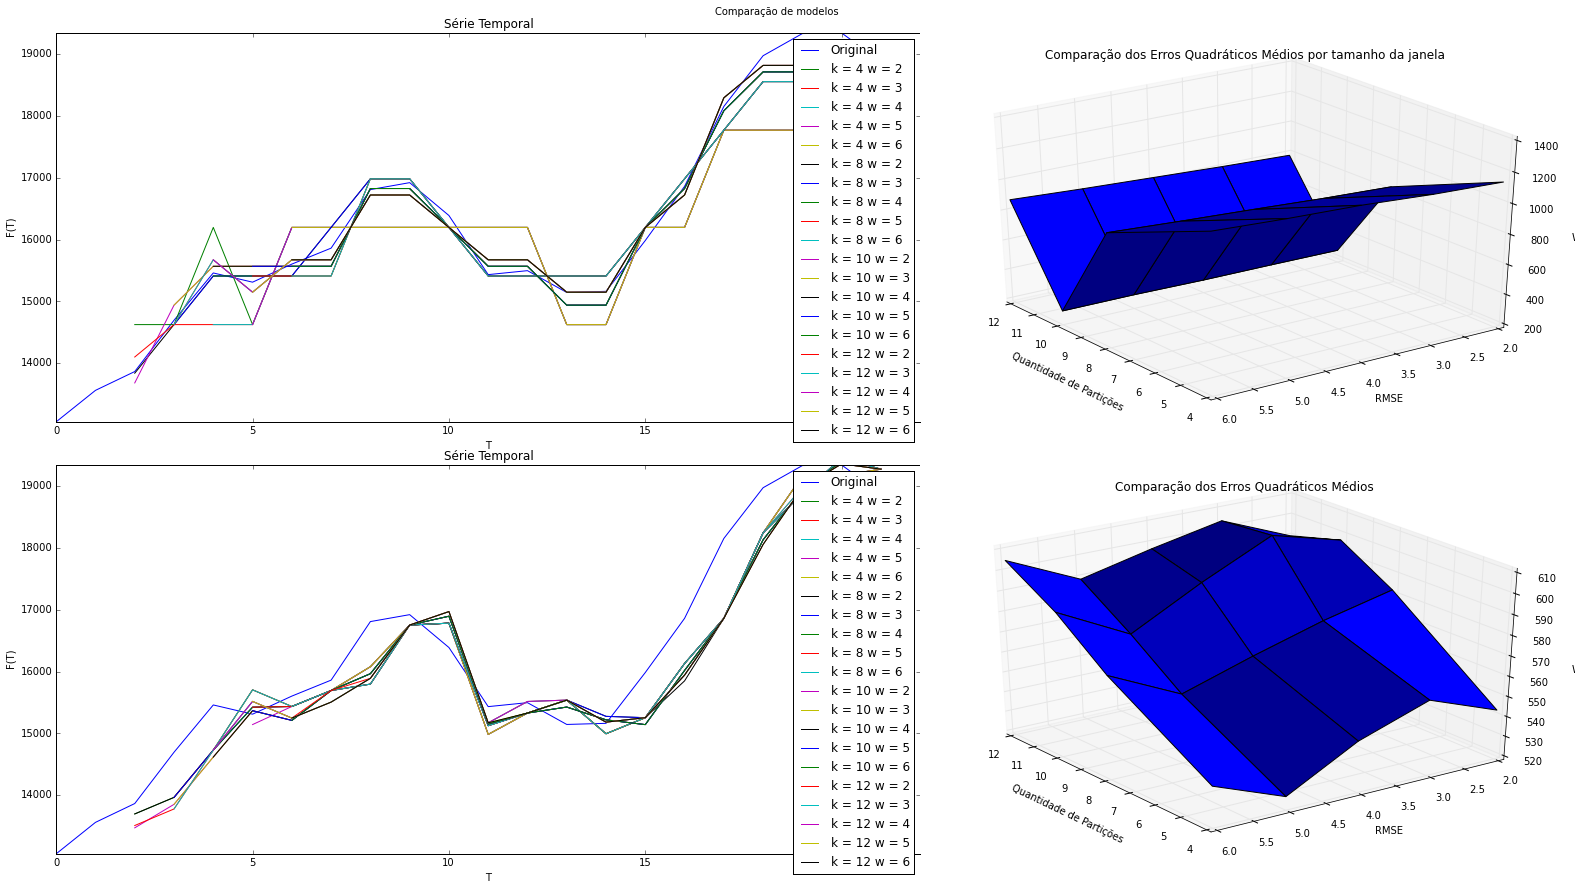

In [126]:
hofts1,hofts1p,hoftsd1,hoftsd1p = HOSelecaoSimples_MenorRMSE(enrollments,[4,8,10,12],[2,3,4,5,6])

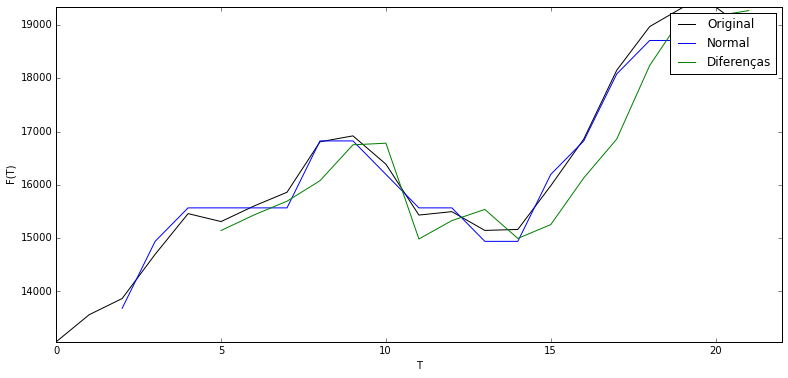

In [127]:
plotCompared(enrollments,[hofts1p,hoftsd1p],["Normal","Diferenças"],'')
enrolments_modelbase_ho.append({"name":"HOFTS","model":hofts1,"predicted":hofts1p})
enrolments_modelbase_ho.append({"name":"HOFTS Dif.","model":hoftsd1,"predicted":hoftsd1p})

## HOFTS - Experimento com o dataset TAIEX

Série Original
2 5 420.57062921
3 5 421.074390874
4 5 421.289762726
5 5 421.697997436
6 5 422.241515409
2 10 221.289804954
3 10 222.366615545
4 10 223.91162587
5 10 225.035331451
6 10 225.810826706
2 15 158.399228661
3 15 160.038495828
4 15 161.092282383
5 15 161.956580208
6 15 162.190150288
2 20 97.3770402887
3 20 98.9555730853
4 20 100.128367177
5 20 100.803960107
6 20 101.044837329
2 25 77.3405880162
3 25 79.1417464992
4 25 79.9399729255
5 25 80.2503027492
6 25 80.3857920219

Série Diferencial
2 5 120.139253189
3 5 116.29864945
4 5 114.679791656
5 5 113.774404806
6 5 113.231350094
2 10 104.202757461
3 10 102.695092483
4 10 102.249016989
5 10 102.23956903
6 10 102.238481147
2 15 101.819865076
3 15 101.407275297
4 15 101.32408971
5 15 101.310091042
6 15 100.892448729
2 20 100.846365148
3 20 100.299884271
4 20 100.222684317
5 20 100.188602273
6 20 99.9597963798
2 25 100.68696984
3 25 100.665035942
4 25 100.589558484
5 25 100.420285523
6 25 100.379561696


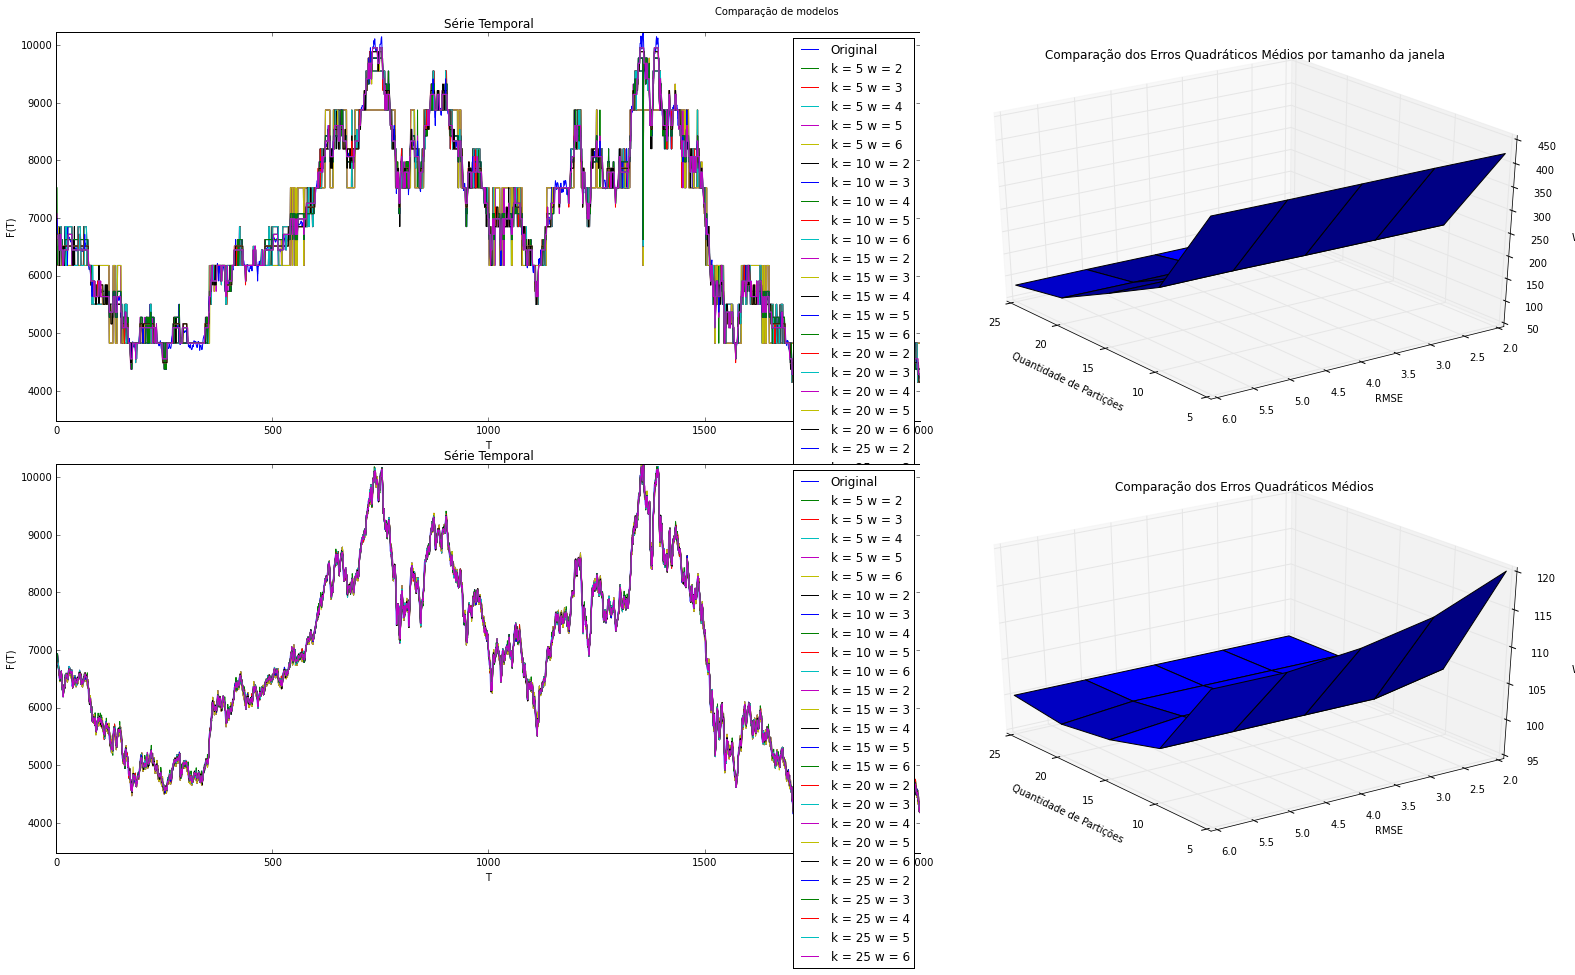

In [56]:
hofts2,hofts2p,hoftsd2,hoftsd2p = HOSelecaoSimples_MenorRMSE(taiexsample,[5,10,15,20,25],[2,3,4,5,6])

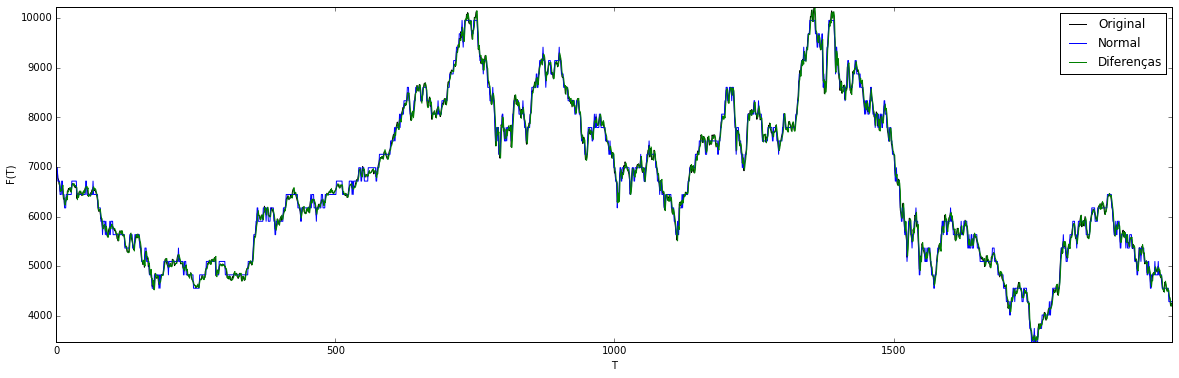

In [57]:
plotCompared(taiexsample,[hofts2p,hoftsd2p],["Normal","Diferenças"],'')
taiex_modelbase_ho.append({"name":"HOFTS","model":hofts2,"predicted":hofts2p})
taiex_modelbase_ho.append({"name":"HOFTS Dif.","model":hoftsd2,"predicted":hoftsd2p})

# Comparação entre os modelos

## Enrollments

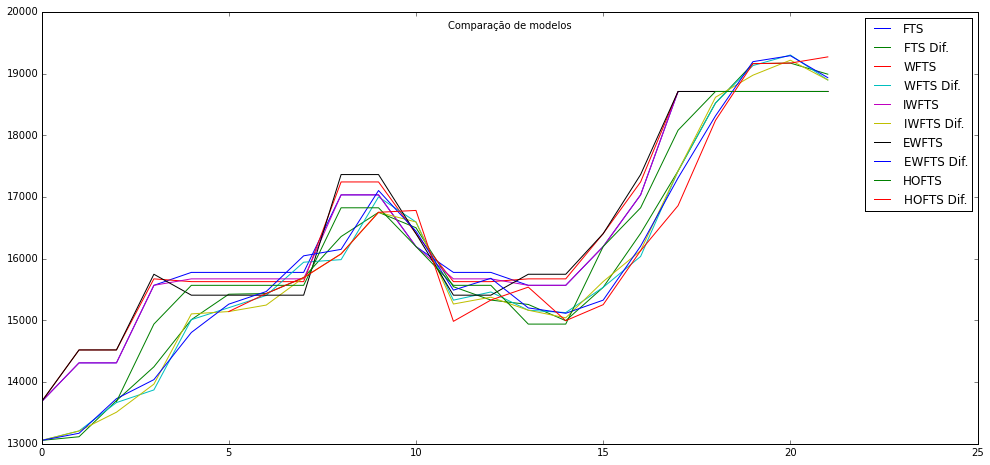

In [108]:
compareModelsPlot(enrollments,enrolments_modelbase_fo,enrolments_modelbase_ho)

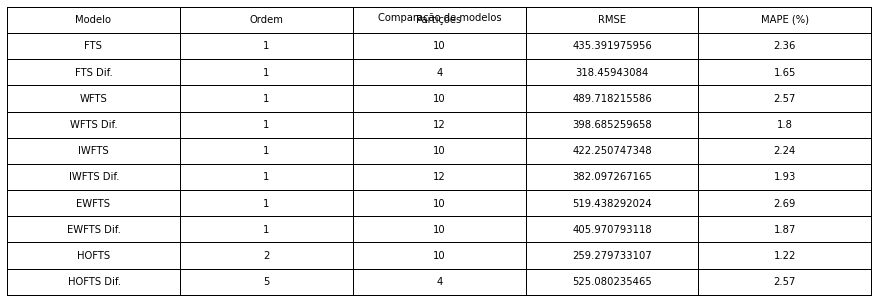

In [86]:
tab = compareModelsTable(enrollments,enrolments_modelbase_fo,enrolments_modelbase_ho)

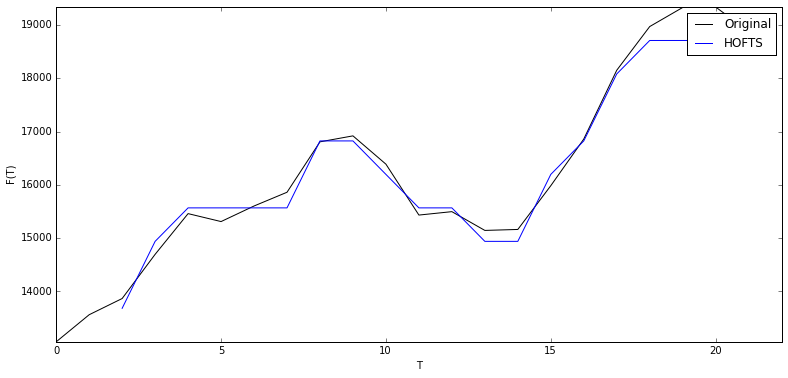

In [113]:
plotCompared(enrollments,[hofts1p],['HOFTS'],'')

In [115]:
print(ftsd1)

4 particoes:
A1 -> A1,A2,A0,A3
A2 -> A1,A2,A3
A0 -> A1
A3 -> A2,A3



In [128]:
for s in hofts1.sets:
    print(s)

A0: <function trimf at 0xaa1b6464>([12426.799999999999, 13055, 13683.200000000001])
A1: <function trimf at 0xaa1b6464>([13055.0, 13683.200000000001, 14311.400000000001])
A2: <function trimf at 0xaa1b6464>([13683.200000000001, 14311.400000000001, 14939.600000000002])
A3: <function trimf at 0xaa1b6464>([14311.400000000001, 14939.600000000002, 15567.800000000003])
A4: <function trimf at 0xaa1b6464>([14939.600000000002, 15567.800000000003, 16196.000000000004])
A5: <function trimf at 0xaa1b6464>([15567.800000000003, 16196.000000000004, 16824.200000000004])
A6: <function trimf at 0xaa1b6464>([16196.000000000004, 16824.200000000004, 17452.400000000005])
A7: <function trimf at 0xaa1b6464>([16824.200000000004, 17452.400000000005, 18080.600000000006])
A8: <function trimf at 0xaa1b6464>([17452.400000000005, 18080.600000000006, 18708.800000000007])
A9: <function trimf at 0xaa1b6464>([18080.600000000006, 18708.800000000007, 19337.000000000007])


## TAIEX

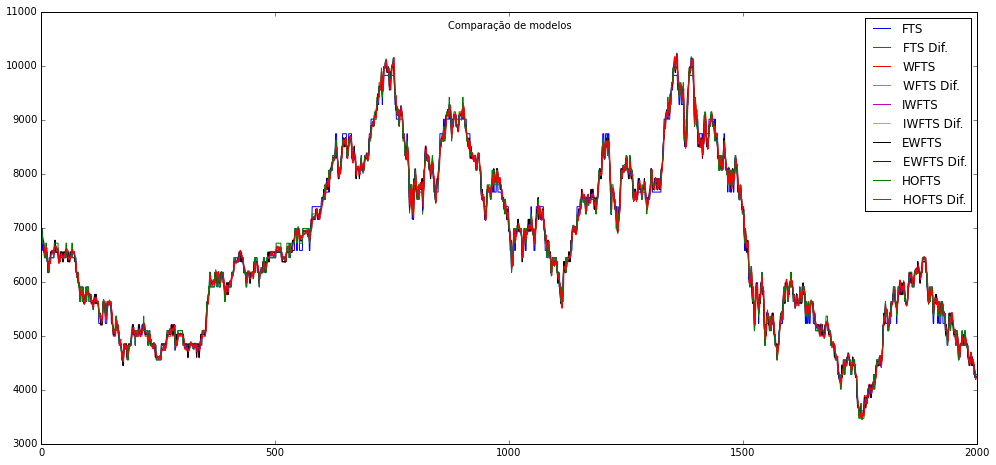

In [107]:
#taiex_modelbase_fo
compareModelsPlot(taiexsample,taiex_modelbase_fo,taiex_modelbase_ho)

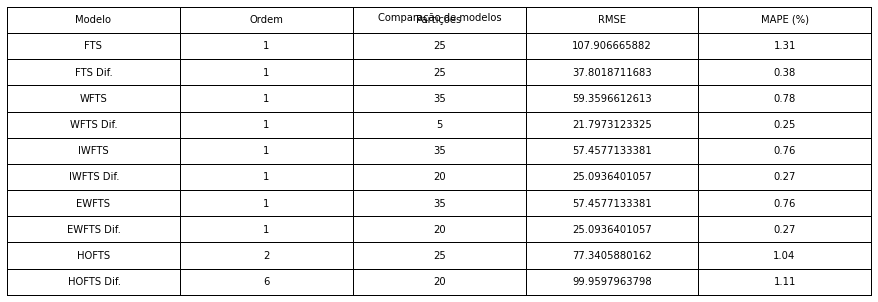

In [89]:
tab = compareModelsTable(taiexsample,taiex_modelbase_fo,taiex_modelbase_ho)

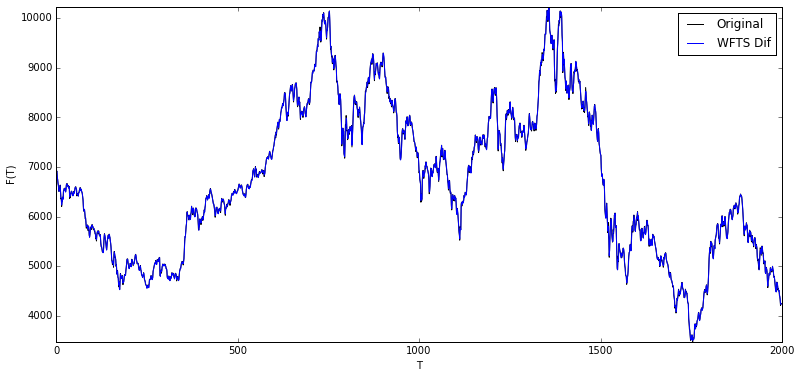

In [121]:
plotCompared(taiexsample,[wftsd2p],['WFTS Dif'],'')

In [135]:
#for s in wfts2.sets: print(wfts2.sets[s])
print(iwfts2)

35 particoes:
A14 -> A14(0.6716417910447762),A13(0.1791044776119403),A15(0.14925373134328357)
A0 -> A0(0.75),A1(0.25)
A8 -> A7(0.1794871794871795),A10(0.02564102564102564),A9(0.1794871794871795),A8(0.6153846153846154)
A6 -> A7(0.09375),A6(0.6875),A5(0.21875)
A32 -> A33(0.23809523809523808),A32(0.47619047619047616),A29(0.047619047619047616),A31(0.23809523809523808)
A3 -> A4(0.2727272727272727),A2(0.09090909090909091),A3(0.6363636363636364)
A1 -> A1(0.5),A2(0.25),A0(0.25)
A10 -> A9(0.15384615384615385),A11(0.23076923076923078),A10(0.6153846153846154)
A9 -> A8(0.2),A9(0.64),A10(0.16)
A19 -> A18(0.16279069767441862),A21(0.023255813953488372),A19(0.6046511627906976),A20(0.20930232558139536)
A17 -> A16(0.09090909090909091),A18(0.25),A15(0.045454545454545456),A17(0.6136363636363636)
A24 -> A23(0.23863636363636365),A25(0.17045454545454544),A24(0.5909090909090909)
A7 -> A7(0.6296296296296297),A6(0.14814814814814814),A9(0.037037037037037035),A8(0.18518518518518517)
A25 -> A25(0.6052631578947368)

# References

(<a id="cit-song1993fuzzy" href="#call-song1993fuzzy">Song and Chissom, 1993</a>) Song Qiang and Chissom Brad S, ``_Fuzzy time series and its models_'', Fuzzy sets and systems, vol. 54, number 3, pp. 269--277,  1993.

(<a id="cit-chen1996forecasting" href="#call-chen1996forecasting">Chen, 1996</a>) Chen Shyi-Ming, ``_Forecasting enrollments based on fuzzy time series_'', Fuzzy sets and systems, vol. 81, number 3, pp. 311--319,  1996.

(<a id="cit-ismail2011enrollment" href="#call-ismail2011enrollment">Ismail and Efendi, 2011</a>) Ismail Zuhaimy and Efendi R, ``_Enrollment forecasting based on modified weight fuzzy time series_'', Journal of Artificial Intelligence, vol. 4, number 1, pp. 110--118,  2011.

(<a id="cit-efendi2013improved" href="#call-efendi2013improved">Efendi, Ismail <em>et al.</em>, 2013</a>) Efendi Riswan, Ismail Zuhaimy and Deris Mustafa Mat, ``_IMPROVED WEIGHT FUZZY TIME SERIES AS USED IN THE EXCHANGE RATES FORECASTING OF US DOLLAR TO RINGGIT MALAYSIA_'', International Journal of Computational Intelligence and Applications, vol. 12, number 01, pp. 1350005,  2013.

(<a id="cit-yu2005weighted" href="#call-yu2005weighted">Yu, 2005</a>) Yu Hui-Kuang, ``_Weighted fuzzy time series models for TAIEX forecasting_'', Physica A: Statistical Mechanics and its Applications, vol. 349, number 3, pp. 609--624,  2005.

(<a id="cit-sadaei2014short" href="#call-sadaei2014short">Sadaei, Enayatifar <em>et al.</em>, 2014</a>) Sadaei Hossein Javedani, Enayatifar Rasul, Abdullah Abdul Hanan <em>et al.</em>, ``_Short-term load forecasting using a hybrid model with a refined exponentially weighted fuzzy time series and an improved harmony search_'', International Journal of Electrical Power \& Energy Systems, vol. 62, number , pp. 118--129,  2014.

(<a id="cit-hwang1998handling" href="#call-hwang1998handling">Hwang, Chen <em>et al.</em>, 1998</a>) Hwang Jeng-Ren, Chen Shyi-Ming and Lee Chia-Hoang, ``_Handling forecasting problems using fuzzy time series_'', Fuzzy sets and systems, vol. 100, number 1, pp. 217--228,  1998.

(<a id="cit-chen2014high" href="#call-chen2014high">Chen, 2014</a>) Chen Mu-Yen, ``_A high-order fuzzy time series forecasting model for internet stock trading_'', Future Generation Computer Systems, vol. 37, number , pp. 461--467,  2014.

